In [1]:
from sympy import *
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.linalg import eigvalsh
from scipy.linalg import eigh
import itertools
from itertools import combinations
import scipy.special
import time
from random import uniform
import pandas as pd
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import csv

In [2]:
def place_ones(size, count, return_int=True):
    # https://stackoverflow.com/questions/43816965/permutation-without-duplicates-in-python
    for positions in combinations(range(size), count):
        p = [0] * size
        for i in positions:
            p[i] = 1
        if return_int == True:
            yield get_int_from_binary_array(p)
        else:
            yield p

def generate_permutations(L, N, return_int=True):
    return list(place_ones(L,N,return_int))

def get_int_from_binary_array(bin_array):
    b = np.array(bin_array)
    return b.dot(2**np.arange(b.size))



def int_get_sign_of(state, i , j, L):
    state_bin = bin_array(state, L)[::-1]
    kj = np.sum(state_bin[:j+1])
    ki = np.sum(state_bin[:i+1])
    #print("State", state_bin, i, j, state_bin[:i+1], state_bin[:j+1], ki, kj)
    
    sign = 0
    if i < j:
        sign = (-1)**(ki+kj-1) 
    elif j < i:
        sign = (-1)**(ki+kj) 
    return sign

def int_generate_transfer_energy(states, L, t):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    Ke_list = [int_compute_KE(state, L) for state in states]
    for i, ke_row in enumerate(Ke_list):
            for j in ke_row:
                result_matrix[i][states.index(abs(j))] = -1* t * np.sign(j)
    return result_matrix

def int_compute_KE(input_state, L):
    ans_list = []
    for i in range(L-1):
        ans_1 = int_ci_dagger_cj(input_state, i, i+1)
        if ans_1 != 0:
            ans_1 *= int_get_sign_of(input_state, i, i+1, L)
            ans_list.append(ans_1)
            
        ans_2 = int_ci_dagger_cj(input_state, i+1, i)
        if ans_2 != 0:
            ans_2 *= int_get_sign_of(input_state, i+1, i, L)
            ans_list.append(ans_2)
    return ans_list

def int_ci_dagger_cj(state, i, j):
    j_int = 2**j
    i_int = 2**i
    if (state & j_int == j_int) and (state & i_int == 0):
        state = state - j_int + i_int
        return state
    else:
        return 0
    
def int_get_electron_density(states, L, eig_vector):
    densities = np.zeros(L)
    for i, state in enumerate(states):
        for position in range(L):
            int_position = 2**position
            if state & int_position == int_position:
                densities[position] += eig_vector[i]**2
    return densities

def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

def get_interaction_energy_sites(x):
    y = x >> 1
    return x&y

def int_generate_interaction_energy(states, L, V):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    for i, state in enumerate(states):
        sites = get_interaction_energy_sites(state)
        sites = bin_array(sites, L)
        sites = sites[::-1]
        int_energy = np.sum(sites) * V
        result_matrix[i][i] = int_energy
    return result_matrix

def int_generate_on_site_energy(states, L, energies=[1,1,1,1]):
    num_of_states = len(states)
    energies = np.array(energies)
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        current_state = np.array(bin_array(states[i],L), dtype=bool)
        energy = np.sum(energies[current_state])
        result_matrix[i][i] = energy 
        
    return result_matrix

def ring_get_interaction_energy_sites(x, L):
    electron_sum = np.sum(bin_array(x,L))
    y = x >> 1
    if electron_sum != np.sum(bin_array(y,L)):
        y += 2**(L-1)
    return x&y


def ring_generate_interaction_energy(states, L, V):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    for i, state in enumerate(states):
        sites = ring_get_interaction_energy_sites(state, L)
        sites = bin_array(sites, L)
        sites = sites[::-1]
        int_energy = np.sum(sites) * V
        result_matrix[i][i] = int_energy
    return result_matrix

def ring_compute_KE(input_state, L):
    ans_list = []
    for i in range(L-1):
        ans_1 = int_ci_dagger_cj(input_state, i, i+1)
        if ans_1 != 0:
            ans_1 *= int_get_sign_of(input_state, i, i+1, L)
            ans_list.append(ans_1)
            
        ans_2 = int_ci_dagger_cj(input_state, i+1, i)
        if ans_2 != 0:
            ans_2 *= int_get_sign_of(input_state, i+1, i, L)
            ans_list.append(ans_2)
            
    
    ans_1 = int_ci_dagger_cj(input_state, L-1, 0)
    if ans_1 != 0:
        ans_1 *= int_get_sign_of(input_state, L-1, 0, L)
        ans_list.append(ans_1)
            
    ans_2 = int_ci_dagger_cj(input_state, 0, L-1)
    if ans_2 != 0:
        ans_2 *= int_get_sign_of(input_state, 0, L-1, L)
        ans_list.append(ans_2)
    
    return ans_list

def ring_generate_transfer_energy(states, L, t):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    Ke_list = [ring_compute_KE(state, L) for state in states]
    for i, ke_row in enumerate(Ke_list):
            for j in ke_row:
                result_matrix[i][states.index(abs(j))] = -1* t * np.sign(j)
    return result_matrix

def int_generate_hamiltonian_matrix(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    states = generate_permutations(L,N, True)
    #print("states", states)
    transfer_m = []
    on_site_m = []
    interaction_m = []
    if is_chain:
        transfer_m = int_generate_transfer_energy(states,L, t=t)
        on_site_m = int_generate_on_site_energy(states, L, energies=on_site_energies)
        interaction_m = int_generate_interaction_energy(states, L, V=V)
    else:
        transfer_m = ring_generate_transfer_energy(states,L, t=t)
        on_site_m = int_generate_on_site_energy(states, L, energies=on_site_energies)
        interaction_m = ring_generate_interaction_energy(states, L, V=V)
        
    '''
    print("Transfer")
    print(transfer_m)
    print("On Site")
    print(on_site_m)
    print("Interaction")
    print(interaction_m)
    '''
    return transfer_m + on_site_m +  interaction_m
    
def int_run_system(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    m = int_generate_hamiltonian_matrix(L=L, N=N, on_site_energies=on_site_energies, t=t, V=V, is_chain=is_chain)
    
    w, v = LA.eig(m)
    
    ground_state_index = np.argmin(w)
    
    states = generate_permutations(L,N, True)
    '''
    
    densities = int_get_electron_density(states,L,v[:,ground_state_index])
    print("ground eig val", w[ground_state_index])
    
    
    print("Matrix sum", sum(densities))
        
    #plt.figure(ground_state_index)
    plt.title("E=" + str(w[ground_state_index]))
    plt.xlabel("Electron Position")
    plt.ylabel("Density")
    plt.bar([str(i) for i in range(len(densities))], densities)
    '''
    
    
    
    for eig_val_index, eig_val in enumerate(w):
        
        densities = int_get_electron_density(states,L,v[:,eig_val_index])
        
        print("V", eig_val, v[:,eig_val_index])
        print("Matrix sum", sum(densities), densities)
        
        plt.figure(eig_val_index)
        plt.title("E=" + str(eig_val))
        plt.xlabel("Electron Position")
        plt.ylabel("Density")
        plt.bar([str(i) for i in range(len(densities))], densities)
    
    
    return m, densities, v[:,ground_state_index];

def getProbabilityMatrix(eig_vec):
    return np.outer(eig_vec, eig_vec)

def generateTrainingData(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    states = generate_permutations(L,N, True)
    transfer_m = []
    on_site_m = []
    interaction_m = []
    if is_chain:
        transfer_m = int_generate_transfer_energy(states,L, t=t)
        on_site_m = int_generate_on_site_energy(states, L, energies=on_site_energies)
        interaction_m = int_generate_interaction_energy(states, L, V=V)
    else:
        transfer_m = ring_generate_transfer_energy(states,L, t=t)
        on_site_m = int_generate_on_site_energy(states, L, energies=on_site_energies)
        interaction_m = ring_generate_interaction_energy(states, L, V=V)
        
    m = transfer_m + on_site_m + interaction_m
    
    eig_results = eigh(m,subset_by_index=[0,1])
    
    result = [0,0]
    
    for i in range(2):
        eig_val = eig_results[0][i]
        eig_vec = eig_results[1][:,i]
        
        densities = int_get_electron_density(states,L,eig_vec)
    
        prob_m = getProbabilityMatrix(eig_vec)
    
        t_sum = np.sum(transfer_m*prob_m)
        on_site_sum = np.sum(on_site_m*prob_m)
        interaction_sum = np.sum(interaction_m*prob_m)
    
        result_dict = {
            "wave_function": eig_vec,
            "densities": densities,
            "total_energy": eig_val,
            "hopping_energy": t_sum,
            "onsite_energy": on_site_sum,
            "interaction_energy": interaction_sum,
            "onsite_energies": on_site_energies
        }
        
        result[i] = result_dict
    
    return result
    
    
def getDeltaString(input_val):
    return str(input_val).replace(".", "")

V 10002.99980006996 [ 9.99900035e-01 -9.99700125e-03 -9.99200490e-09 -9.99500225e-05
  9.99800055e-03 -9.99800075e-05]
Matrix sum 2.0000000000000004 [9.9990002e-01 9.9990005e-01 9.9960020e-05 9.9970011e-05]
V 10102.999948515602 [-0.0070693   0.00713999 -0.00707001 -0.70707091  0.70700127 -0.00700001]
Matrix sum 2.000000000000001 [1.50939398e-04 9.99850035e-01 5.00049250e-01 4.99949775e-01]
V 9902.999951514379 [ 0.0070693   0.00699861  0.00707001 -0.70707197 -0.70700021  0.00714142]
Matrix sum 2.000000000000001 [1.48940648e-04 9.99850035e-01 5.00050750e-01 4.99950275e-01]
V -99.50100179151688 [-0.00701645 -0.70876689 -0.70530209 -0.00708695 -0.0071218  -0.00694803]
Matrix sum 1.9999999999999998 [9.99850780e-01 1.50175477e-04 5.02449009e-01 4.97550036e-01]
V 100.50150169153952 [ 0.00712246  0.70523015 -0.70883636  0.0070516  -0.0070157   0.00719548]
Matrix sum 2.0 [9.99849280e-01 1.49674584e-04 4.97451071e-01 5.02549974e-01]
V 1.9998000000119998 [-1.00009990e-04 -1.00009992e-02  9.998998

'\n4C2: 0.0019991397857666016, 0.002000570297241211\n6C3: 0.007445573806762695, 0.001999378204345703\n8C4: 0.04017496109008789, 0.013108015060424805\n10C5:  0.642479658126831, 0.11253833770751953\n12C6: 9.390473127365112, 0.9498190879821777\n14C7: long, 41.105031967163086\n'

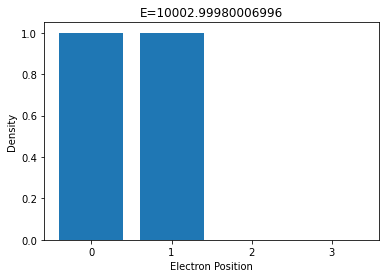

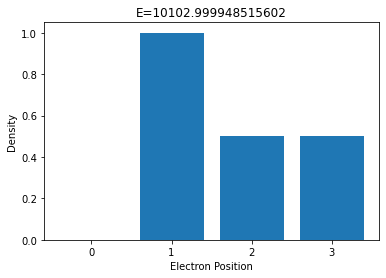

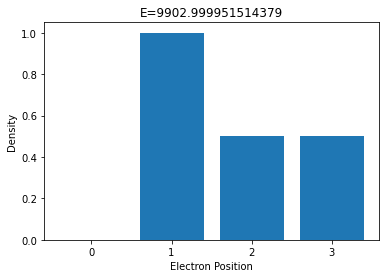

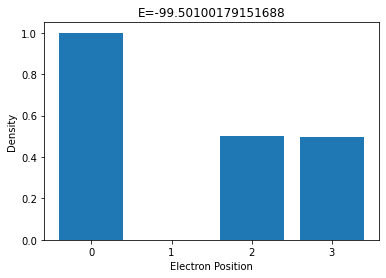

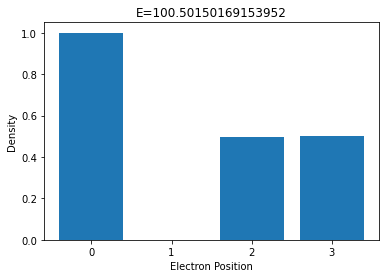

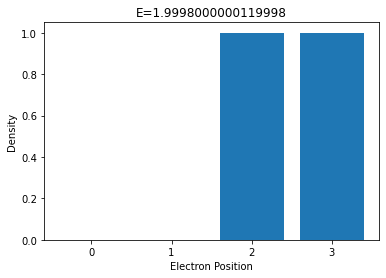

In [40]:
L = 4
N = 2
e_0 = 1
t=100
V=1
delta = 0.1
energies = [e_0+uniform(-1 * delta, delta) for i in range(L)]

one_energies = [1 for i in range(L)]

ring_energies = [1,1,1,1,1,1]

zero_energies = [0 for i in range(L)]

inf_energies = zero_energies[:]
inf_energies[0] = 1000

d_energies = [1,1,10000,1]

start = time.time()
m, d, u = int_run_system(L=L, N=N, on_site_energies=d_energies, t=t, V=V, is_chain=True)
end = time.time()
print("Time:", end - start)
#print(m)
#plt.imshow(m)
#plt.colorbar()
#d

'''
4C2: 0.0019991397857666016, 0.002000570297241211
6C3: 0.007445573806762695, 0.001999378204345703
8C4: 0.04017496109008789, 0.013108015060424805
10C5:  0.642479658126831, 0.11253833770751953
12C6: 9.390473127365112, 0.9498190879821777
14C7: long, 41.105031967163086
'''

In [7]:
generateTrainingData(L=4, N=2, on_site_energies=[1,1,1,1], t=1, V=1, is_chain=True)

[{'wave_function': array([-0.17407766, -0.52223297, -0.52223297, -0.34815531, -0.52223297,
         -0.17407766]),
  'densities': array([0.57575758, 0.42424242, 0.42424242, 0.57575758]),
  'total_energy': 3.865734404318223e-17,
  'hopping_energy': -2.1818181818181817,
  'onsite_energy': 1.9999999999999998,
  'interaction_energy': 0.1818181818181818,
  'onsite_energies': [1, 1, 1, 1]},
 {'wave_function': array([ 3.71748034e-01,  6.01500955e-01, -2.94822415e-16,  1.31685308e-16,
         -6.01500955e-01, -3.71748034e-01]),
  'densities': array([0.5, 0.5, 0.5, 0.5]),
  'total_energy': 1.3819660112501055,
  'hopping_energy': -0.8944271909999156,
  'onsite_energy': 1.9999999999999993,
  'interaction_energy': 0.276393202250021,
  'onsite_energies': [1, 1, 1, 1]}]

In [8]:
data_columns = {'wave_function', 'densities', 'total_energy','hopping_energy','onsite_energy','interaction_energy','onsite_energies'}

result_ground_df = pd.DataFrame(columns=data_columns)
result_first_df = pd.DataFrame(columns=data_columns)

L = 4
N = 2
V = 1
delta = 0.001
is_chain = False
num_of_data_points = 750

start = time.time()
for i in range(num_of_data_points):
    if i % 10 == 0:
        print(i)
    result = generateTrainingData(L=L, N=N, on_site_energies=list(np.random.uniform(-1*delta,delta,L)), t=1, V=V, is_chain=is_chain)
    result_ground_df = result_ground_df.append(result[0],ignore_index=True)
    result_first_df = result_first_df.append(result[1],ignore_index=True)
    
end = time.time()
print("Time:", end - start)

result_ground_df

# t always = 1
# V = 1,4,6 (directory for each one)
# os => delta = 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 3 (units of t), 500 points for each disorder, e_0=0, save input energies
# tensorflow (keras)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
Time: 4.569835662841797


,total_energy,wave_function,interaction_energy,onsite_energies,densities,onsite_energy,hopping_energy
0,-1.562919,"[0.3077429281562356, -3.001973516705639e-06, -...",0.378661,"[-0.0008187509172950283, 0.0003965744699002357...","[0.18941543250073117, 0.8106669034013901, 0.18...",-0.001367,-1.940214
1,-1.561854,"[0.30777037668357604, 1.9495694954265693e-05, ...",0.378679,"[-0.00015315003829637379, 0.000797579803501793...","[0.18942309293820028, 0.810673453470101, 0.189...",-0.000301,-1.940231
2,-1.562734,"[-0.3076015577219882, -0.7882692019483273, -0....",0.378632,"[-0.0002718660683760887, -0.000943589184853765...","[0.8106566611160329, 0.18925740933203702, 0.81...",-0.001181,-1.940184
3,-1.562922,"[-0.3076022394071799, -0.7882744963729252, -0....",0.378623,"[-0.00036675608285635414, -0.00092335082976306...","[0.8106797703988986, 0.18924434838219764, 0.81...",-0.001370,-1.940176
4,-1.561878,"[-0.30766934635350457, -0.7882496413552541, -0...",0.378663,"[-2.5556829989707317e-05, 0.000170457229054129...","[0.8107350477821866, 0.18927828312477096, 0.81...",-0.000325,-1.940215
...,...,...,...,...,...,...,...
745,-1.562159,"[0.3076360473271693, -2.207663924285034e-06, -...",0.378595,"[-0.0004553563822365734, 0.0004812825732182586...","[0.1892698366467599, 0.810713471859853, 0.1893...",-0.000607,-1.940148
746,-1.560299,"[-0.30765074441989504, -0.7882333700110735, -0...",0.378688,"[0.0009393926240626959, 0.0002420313081167118,...","[0.8106098311627359, 0.18934402893618557, 0.81...",0.001254,-1.940241
747,-1.561380,"[-0.30766497546952026, -0.7882293188972144, -0...",0.378695,"[0.0005416588028372496, -0.0002751124848893096...","[0.8106085176688204, 0.1893750300294733, 0.810...",0.000173,-1.940247
748,-1.562831,"[-0.30766851709742865, -0.7882338983170013, -0...",0.378687,"[-9.950547964036492e-05, -0.000998033979828274...","[0.8106142763617283, 0.18937630111222148, 0.81...",-0.001278,-1.940240


In [3]:
# save data to file
# L N type V T

data_type = "chain"

if is_chain == False:
    data_type = "ring"


file_name_prefix = "data/" + data_type + "_" + str(L) + "_" + str(N) + "_" + str(V) + "_" + getDeltaString(delta) + "_"

result_ground_df.to_csv(file_name_prefix + "ground.csv", encoding='utf-8', index=False)
result_first_df.to_csv(file_name_prefix + "first.csv", encoding='utf-8', index=False)

NameError: name 'is_chain' is not defined

In [27]:
# 1000 data points
# 4C2: 5.75s
# 6C3: 6.83s
# 8C4: 15.64s
# 10C5: 63.86s
# 12C6: 329.17s
# 14C7: 41s for 9 => 4.56 for 1 => 4560s for 1000 => 76 mins for 1000

# Values to generate training data?

In [41]:
data_df = pd.read_csv(file_name_prefix + "ground.csv") 
data_df

,interaction_energy,densities,hopping_energy,wave_function,total_energy,onsite_energy
0,0.181818,[0.57575758 0.42424242 0.42424242 0.57575758],-2.181818,[-0.17407766 -0.52223297 -0.52223297 -0.348155...,3.865734e-17,2.0
1,0.181818,[0.57575758 0.42424242 0.42424242 0.57575758],-2.181818,[-0.17407766 -0.52223297 -0.52223297 -0.348155...,3.865734e-17,2.0
2,0.181818,[0.57575758 0.42424242 0.42424242 0.57575758],-2.181818,[-0.17407766 -0.52223297 -0.52223297 -0.348155...,3.865734e-17,2.0
3,0.181818,[0.57575758 0.42424242 0.42424242 0.57575758],-2.181818,[-0.17407766 -0.52223297 -0.52223297 -0.348155...,3.865734e-17,2.0
4,0.181818,[0.57575758 0.42424242 0.42424242 0.57575758],-2.181818,[-0.17407766 -0.52223297 -0.52223297 -0.348155...,3.865734e-17,2.0
...,...,...,...,...,...,...
995,0.181818,[0.57575758 0.42424242 0.42424242 0.57575758],-2.181818,[-0.17407766 -0.52223297 -0.52223297 -0.348155...,3.865734e-17,2.0
996,0.181818,[0.57575758 0.42424242 0.42424242 0.57575758],-2.181818,[-0.17407766 -0.52223297 -0.52223297 -0.348155...,3.865734e-17,2.0
997,0.181818,[0.57575758 0.42424242 0.42424242 0.57575758],-2.181818,[-0.17407766 -0.52223297 -0.52223297 -0.348155...,3.865734e-17,2.0
998,0.181818,[0.57575758 0.42424242 0.42424242 0.57575758],-2.181818,[-0.17407766 -0.52223297 -0.52223297 -0.348155...,3.865734e-17,2.0


# Old code

In [ ]:
def int_generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
    int_unique_perms = [get_int_from_binary_array(i) for i in get_unique(itertools.permutations(input_list, r=L))]
    return int_unique_perms

def get_unique(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [ ]:
def generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
    perms = list(itertools.permutations(input_list))
    unique_perms = list(dict.fromkeys(perms))
    return unique_perms

def generate_on_site_energy(states, energies=[1,1,1,1]):
    num_of_states = len(states)
    #print(num_of_states)
    
    energies = np.array(energies)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        current_state = np.array(states[i], dtype=bool)
        energy = np.sum(energies[current_state])
        result_matrix[i][i] = energy 
        
    return result_matrix


def get_int_from_binary_array(bin_array):
    bin_string = ""
    for bit in bin_array[::-1]:
        bin_string += str(bit)
    return int(bin_string, 2)

def get_interaction_energy_sites(x):
    y = x >> 1
    return x&y

def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

def generate_interaction_energy(states, V):
    num_of_states = len(states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i, state in enumerate(states):
        sites = get_interaction_energy_sites(get_int_from_binary_array(state))
        sites = bin_array(sites, len(states[0]))
        sites = sites[::-1]
        int_energy = np.sum(sites) * V
        result_matrix[i][i] = int_energy
    
    return result_matrix

def ci_dagger_cj(state, i, j):
    L = len(state)
    if (j >= L) or (i >= L):
        return 0 
    
    if (state[j] == 1) and (state[i] == 0):
        result_state = state[:]
        result_state[j] = 0
        result_state[i] = 1
        return result_state
    else:
        return 0
    
def get_sign_of(state, i , j):
    L = len(state)
    kj = 0
    ki = 0
    
    # could add in sum() for contracted state
    for position in range(j):
        if state[position] == 1:
            kj += 1
            
    for position in range(i):
        if state[position] == 1:
            ki += 1
            
    sign = 0
    if i < j:
        sign = (-1)**(ki+kj-1) 
        
    elif j < i:
        sign = (-1)**(ki+kj) 

    return sign

def compute_KE(input_state):
    L = len(input_state)
    ans_list = []
    for i in range(L-1):
        ans_1 = ci_dagger_cj(input_state, i, i+1)
        if ans_1 != 0:
            ans_1 = get_sign_of(input_state, i, i+1) * get_int_from_binary_array(ans_1)
            ans_list.append(int(ans_1))
            
        ans_2 = ci_dagger_cj(input_state, i+1, i)
        if ans_2 != 0:
            ans_2 = get_sign_of(input_state, i+1, i) * get_int_from_binary_array(ans_2)
            ans_list.append(int(ans_2))
       
    return ans_list

def generate_transfer_energy(states, t):
    num_of_states = len(states)
    #result_matrix = np.zeros((num_of_states,num_of_states))
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    state_as_ints = [get_int_from_binary_array(state) for state in states]
    
    Ke_list = [compute_KE(list(state)) for state in states]
    
    for i, ke_row in enumerate(Ke_list):
            for j in ke_row:
                result_matrix[i][state_as_ints.index(abs(j))] = -1* t * np.sign(j)
    
    return result_matrix

def generate_hamiltonian_matrix(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    states = generate_permutations(L,N)
    if is_chain:
        return generate_on_site_energy(states, on_site_energies) + generate_transfer_energy(states, t=t) + generate_interaction_energy(states, V=V) 
    
def get_electron_density(states, eig_vector):
    L = len(states[0])
    densities = np.zeros(L)
    for i, state in enumerate(states):
        for j, bit in enumerate(state):
            if bit == 1:
                densities[j] += eig_vector[i]**2
    return densities

def run_system(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    m = generate_hamiltonian_matrix(L=L, N=N, on_site_energies=on_site_energies, t=t, V=V, is_chain=is_chain)
    
    w, v = LA.eig(m)
    
    states = generate_permutations(L,N)

    for eig_val_index, eig_val in enumerate(w):
        # Need to fix the density function to accomodation abitrary L and N
        print(states, v[:,eig_val_index])
        densities = get_electron_density(states,v[:,eig_val_index])
        print("Matrix sum", sum(densities))
        plt.figure(eig_val_index)
        plt.title("E=" + str(eig_val))
        plt.xlabel("Electron Position")
        plt.ylabel("Density")
        plt.bar([str(i) for i in range(len(densities))], densities)
        
    return m

In [ ]:
L = 4
N = 2
energies = [1 for i in range(L)]
run_system(L=L, N=N, on_site_energies=energies, t=1, V=1, is_chain=True)

In [ ]:
ci_dagger_cj([1,0,0,1], 2, 4)

In [ ]:
m = generate_hamiltonian_matrix(L=8, N=4, on_site_energies=[1,1,1,1,1,1,1,1], t=1, V=1, is_chain=True)

plt.imshow(m)
plt.colorbar()

In [ ]:
[(i, scipy.special.comb(i, i//2, exact=True)) for i in range(4,100,2)]


In [ ]:
'''
|1> = |1,1,0,0>
|2> = |1,0,1,0>
|3> = |1,0,0,1>
|4> = |0,1,1,0>
|5> = |0,1,0,1>
|6> = |0,0,1,1>
'''

def no_4114_numpy_generate_4_atom_2_electron_chain_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(np.array([
        [e1+e2+V,-t   ,0    ,0      ,0    ,0],
        [-t     ,e1+e3,-t   ,-t     ,0    ,0],
        [0      ,-t   ,e1+e4,0      ,-t   ,0],
        [0      ,-t   ,0    ,e2+e3+V,-t   ,0],
        [0      ,0    ,-t   ,-t     ,e2+e4,-t],
        [0      ,0    ,0    ,0      ,-t   ,e3+e4+V]
    ]))

def no_4114_numpy_generate_4_atom_2_electron_ring_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(np.array([
        [e1+e2+V,-t   ,0      ,0      ,-t   ,0],
        [-t     ,e1+e3,-t     ,-t     ,0    ,-t],
        [0      ,-t   ,e1+e4+V,0      ,-t   ,0],
        [0      ,-t   ,0      ,e2+e3+V,-t   ,0],
        [-t     ,0    ,-t     ,-t     ,e2+e4,-t],
        [0      ,-t   ,0      ,0      ,-t   ,e3+e4+V]
    ]))


def get_electron_density_from_eigenvector_4atom_2electron(eig_vector):
        # eigenvector[Position-1] 
        density_at_position_1 = eig_vector[1-1]**2 + eig_vector[2-1]**2 + eig_vector[3-1]**2
        density_at_position_2 = eig_vector[1-1]**2 + eig_vector[4-1]**2 + eig_vector[5-1]**2
        density_at_position_3 = eig_vector[2-1]**2 + eig_vector[4-1]**2 + eig_vector[6-1]**2
        density_at_position_4 = eig_vector[3-1]**2 + eig_vector[5-1]**2 + eig_vector[6-1]**2
        return([density_at_position_1,density_at_position_2,density_at_position_3,density_at_position_4])

In [ ]:
# Higher V higher range/deviation, some positions are near 1 others near 0
# Higher e values => more dispersion
# Higher t values => less dispersion, kinetic energy is trasfered between and smooths out?

m_chain_V0 =  no_4114_numpy_generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=0)
m_chain_V2 =  no_4114_numpy_generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=2)
m_chain_V5 =  no_4114_numpy_generate_4_atom_2_electron_chain_matrix(e1=10, e2=10, e3=10, e4=10, t=1, V=5)
m_chain_V10 =  no_4114_numpy_generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=10)

m_ring_V0 =  no_4114_numpy_generate_4_atom_2_electron_ring_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=0)
m_ring_V2 =  no_4114_numpy_generate_4_atom_2_electron_ring_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=2)
m_ring_V5 =  no_4114_numpy_generate_4_atom_2_electron_ring_matrix(e1=10, e2=10, e3=10, e4=10, t=1, V=5)
m_ring_V10 =  no_4114_numpy_generate_4_atom_2_electron_ring_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=10)

In [ ]:
# Code to aumomatically generate the hamiltonian matrix
# permutation function in python => numpy has library

def generate_states(L, N):
    set_of_states = []
    
    current_state = np.zeros(L).astype(int).tolist()
    for i in range(N):
        current_state[i] = 1
        
    set_of_states.append(current_state)
    
    final_state = current_state[::-1]
    
    while current_state != final_state:
        current_state = generate_next_state(current_state[:])
        set_of_states.append(current_state[:])
    
    return set_of_states

def get_index_of_last_value(input_list, value):
    L = len(input_list)
    return (L- 1 - input_list[::-1].index(value))


def generate_next_state(current_state, level=0):
    result_state = current_state
    L = len(current_state)
    # get index of last 1
    final_1_index = get_index_of_last_value(current_state, 1)
    
    if(final_1_index == (L-1-level)):
        #print("is in final position")
        # go to next position
        interim_state = current_state
        interim_state[final_1_index] = 0
        interim_state = generate_next_state(interim_state, level+1)
        result_state = interim_state
        final_index = get_index_of_last_value(result_state, 1)
        result_state[final_index + 1] = 1
        return result_state
    else:
        #print("Not in final")
        result_state[final_1_index] = 0
        result_state[final_1_index+1] = 1
        return result_state
    
def generate_on_site_energy(states, energies=[1,1,1,1]):
    num_of_states = len(states)
    #print(num_of_states)
    
    energies = np.array(energies)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        current_state = np.array(states[i], dtype=bool)
        energy = np.sum(energies[current_state])
        result_matrix[i][i] = energy 
        
    return result_matrix

def generate_interaction_energy(states, V=1):
    num_of_states = len(states)
    #print(num_of_states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        current_state = states[i]
        interation_energy_sum = 0
        for j in range(len(current_state)-1):
            if(current_state[j]==1 and current_state[j+1]==1):
                interation_energy_sum += V
        result_matrix[i][i] = interation_energy_sum 
    
    return result_matrix

def generate_transfer_energy(states, t=-1):
    num_of_states = len(states)
    #print(num_of_states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        for j in range(num_of_states):
            state_1 = np.array(states[i])
            state_2 = np.array(states[j])
            mixed_state = state_2 - state_1
            #print(i+1,j+1, mixed_state)
            if (np.count_nonzero(mixed_state == -1)==1 and np.count_nonzero(mixed_state == 1)==1):
                minus_one_index = np.where(mixed_state == -1)[0]
                one_index = np.where(mixed_state == 1)[0]
                #print("Potential t", minus_one_index, one_index)
                if((one_index-minus_one_index)**2 == 1):
                    #print("Is t")
                    result_matrix[i][j] = t
                    
    return result_matrix

def generate_transfer_energy_for_ring(states, t=-1):
    num_of_states = len(states)
    #print(num_of_states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        for j in range(num_of_states):
            state_1 = np.array(states[i])
            state_2 = np.array(states[j])
            mixed_state = state_2 - state_1
            #print(i+1,j+1, mixed_state)
            if (np.count_nonzero(mixed_state == -1)==1 and np.count_nonzero(mixed_state == 1)==1):
                minus_one_index = np.where(mixed_state == -1)[0]
                one_index = np.where(mixed_state == 1)[0]
                #print("Potential t", minus_one_index, one_index)
                if((one_index-minus_one_index)**2 == 1):
                    #print("Is t")
                    result_matrix[i][j] = t
                if((minus_one_index==0 and one_index==len(mixed_state)-1) or (one_index==0 and minus_one_index==len(mixed_state)-1)):
                    result_matrix[i][j] = t
                    
    return result_matrix

def generate_interaction_energy_for_ring(states, V=1):
    num_of_states = len(states)
    #print(num_of_states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        current_state = states[i]
        interation_energy_sum = 0
        for j in range(len(current_state)):
            if j == len(current_state)-1:
                if(current_state[j]==1 and current_state[0]==1):
                    interation_energy_sum += V
            else:
                if(current_state[j]==1 and current_state[j+1]==1):
                    interation_energy_sum += V
        result_matrix[i][i] = interation_energy_sum 
    
    return result_matrix

def generate_hamiltonian_matrix(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    states = generate_states(L,N)
    if is_chain:
        return generate_on_site_energy(states, on_site_energies) + generate_transfer_energy(states, t=t) + generate_interaction_energy(states, V=V) 
    else:
        return generate_on_site_energy(states, on_site_energies) + generate_transfer_energy_for_ring(states, t=t) + generate_interaction_energy_for_ring(states, V=V) 

In [ ]:
m_auto = generate_hamiltonian_matrix(L=6, N=3, on_site_energies=[5,5,5,5,5,5], t=-5, V=10)
m_auto
# safe range on machine? N = L/2

In [ ]:
# copmare time to compute between scipy and numpy

m = m_auto
w, v = LA.eig(m)

for eig_val_index, eig_val in enumerate(w):
    # Need to fix the density function to accomodation abitrary L and N
    densities = get_electron_density_from_eigenvector_4atom_2electron(v[:,eig_val_index])
    print("Matrix sum", sum(densities))
    plt.figure(eig_val_index)
    plt.title("E=" + str(eig_val))
    plt.xlabel("Electron Position")
    plt.ylabel("Density")
    plt.bar(["1","2","3","4"], densities)

# Workspace

In [ ]:
# chain = ring for 2 atom 1 elec
'''
[
    [e_1, -t],
    [-t, e_2]
]
'''
m_2_1_chain_No_V = Matrix([[1,-1],[-1,1]])

In [ ]:
m_2_1_chain_No_V.diagonalize()[1]
m_2_1_chain_No_V.eigenvals()
m_2_1_chain_No_V.eigenvects()

In [ ]:
e_1=Symbol('e_1') 
e_2=Symbol('e_2') 
t=Symbol('t') 

m_2_1_chain_No_V_analytic = Matrix([[e_1,-t],[-t,e_2]])

In [ ]:
m_2_1_chain_No_V_analytic.diagonalize()

In [ ]:
def sympy_generate_4_atom_2_electron_chain_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(Matrix([
        [e1+e2+V,-t   ,0    ,-t     ,0    ,0],
        [-t     ,e1+e3,-t   ,-t     ,0    ,0],
        [0      ,-t   ,e1+e4,0      ,-t   ,0],
        [-t     ,-t   ,0    ,e2+e3+V,-t   ,0],
        [0      ,0    ,-t   ,-t     ,e2+e4,-t],
        [0      ,0    ,0    ,0      ,-t   ,e3+e4+V]
    ]))

In [ ]:
sympy_generate_4_atom_2_electron_chain_matrix(e2=1)

In [ ]:
s_e1=Symbol('e1') 
s_e2=Symbol('e2') 
s_e3=Symbol('e3') 
s_e4=Symbol('e4') 
s_t=Symbol('t') 
s_V=Symbol('V') 

In [ ]:
m = sympy_generate_4_atom_2_electron_chain_matrix(e1=s_e1, e2=s_e2, e3=s_e3, e4=s_e4, t=s_t, V=0)

In [ ]:
m = generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=1)

In [ ]:
m.eigenvals(rational=False)

In [ ]:
generate_4_atom_2_electron_chain_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0)

In [ ]:
'''
|1> = |1,1,0,0>
|2> = |1,0,1,0>
|3> = |1,0,0,1>
|4> = |0,1,1,0>
|5> = |0,1,0,1>
|6> = |0,0,1,1>
'''


def numpy_generate_4_atom_2_electron_chain_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(np.array([
        [e1+e2+V,-t   ,0    ,-t     ,0    ,0],
        [-t     ,e1+e3,-t   ,-t     ,0    ,0],
        [0      ,-t   ,e1+e4,0      ,-t   ,0],
        [-t     ,-t   ,0    ,e2+e3+V,-t   ,0],
        [0      ,0    ,-t   ,-t     ,e2+e4,-t],
        [0      ,0    ,0    ,0      ,-t   ,e3+e4+V]
    ]))

In [ ]:
numpy_generate_4_atom_2_electron_chain_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0)

In [ ]:
m = numpy_generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=0)
m

In [ ]:
eig_result = LA.eig(m)
eig_result[1][0]

In [ ]:
array_2 = np.array([[1,-1],[-1,1]])

In [ ]:
LA.eig(array_2)

In [ ]:
 def get_electron_density_from_eigenvector_4atom_2electron(eig_vector):
        result = []
        density_at_position_1 = eig_vector[0]**2 + eig_vector[1]**2 + eig_vector[2]**2
        density_at_position_2 = eig_vector[0]**2 + eig_vector[3]**2 + eig_vector[4]**2
        density_at_position_3 = eig_vector[1]**2 + eig_vector[3]**2 + eig_vector[4]**2
        density_at_position_4 = eig_vector[2]**2 + eig_vector[4]**2 + eig_vector[5]**2
        return([density_at_position_1,density_at_position_2,density_at_position_3,density_at_position_4])

In [ ]:
density_result = get_electron_density_from_eigenvector_4atom_2electron(eig_result[1][0])

In [ ]:
for position, value in enumerate(density_result):
    print (position+1, value)

In [ ]:
plt.bar(["1","2","3","4"], density_result)

In [ ]:
m = numpy_generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=0)
eig_result = LA.eig(m)

for eig_val_index, eig_vec in enumerate(eig_result[1]):
    eig_val = eig_result[0][eig_val_index]
    densities = get_electron_density_from_eigenvector_4atom_2electron(eig_vec)
    plt.figure(eig_val_index)
    plt.title("E=" + str(eig_val))
    plt.xlabel("Electron Position")
    plt.ylabel("Density")
    plt.bar(["1","2","3","4"], densities)

In [ ]:
def numpy_generate_4_atom_2_electron_ring_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(np.array([
        [e1+e2+V,-t   ,0      ,-t      ,-t   ,0],
        [-t     ,e1+e3,-t     ,-t     ,0    ,-t],
        [0      ,-t   ,e1+e4+V,0      ,-t   ,0],
        [-t      ,-t   ,0      ,e2+e3+V,-t   ,0],
        [-t     ,0    ,-t     ,-t     ,e2+e4,-t],
        [0      ,-t   ,0      ,0      ,-t   ,e3+e4+V]
    ]))

In [ ]:
ring_0 = numpy_generate_4_atom_2_electron_ring_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=0)

In [ ]:
def no_4114_numpy_generate_4_atom_2_electron_chain_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(np.array([
        [e1+e2+V,-t   ,0    ,0      ,0    ,0],
        [-t     ,e1+e3,-t   ,-t     ,0    ,0],
        [0      ,-t   ,e1+e4,0      ,-t   ,0],
        [0      ,-t   ,0    ,e2+e3+V,-t   ,0],
        [0      ,0    ,-t   ,-t     ,e2+e4,-t],
        [0      ,0    ,0    ,0      ,-t   ,e3+e4+V]
    ]))

In [ ]:
m_new_format =  no_4114_numpy_generate_4_atom_2_electron_chain_matrix(e1=10, e2=10, e3=10, e4=10, t=1, V=0)

In [ ]:
def numpy_generate_4_atom_2_electron_ring_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(np.array([
        [e1+e2+V,-t   ,0      ,-t     ,-t   ,0],
        [-t     ,e1+e3,-t     ,-t     ,0    ,-t],
        [0      ,-t   ,e1+e4+V,0      ,-t   ,0],
        [-t     ,-t   ,0      ,e2+e3+V,-t   ,0],
        [-t     ,0    ,-t     ,-t     ,e2+e4,-t],
        [0      ,-t   ,0      ,0      ,-t   ,e3+e4+V]
    ]))

In [ ]:
def no_4114_numpy_generate_4_atom_2_electron_ring_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(np.array([
        [e1+e2+V,-t   ,0      ,0      ,-t   ,0],
        [-t     ,e1+e3,-t     ,-t     ,0    ,-t],
        [0      ,-t   ,e1+e4+V,0      ,-t   ,0],
        [0      ,-t   ,0      ,e2+e3+V,-t   ,0],
        [-t     ,0    ,-t     ,-t     ,e2+e4,-t],
        [0      ,-t   ,0      ,0      ,-t   ,e3+e4+V]
    ]))

In [ ]:
m_ring =  no_4114_numpy_generate_4_atom_2_electron_ring_matrix(e1=100, e2=100, e3=100, e4=100, t=1, V=10)

In [ ]:
def no_4114_numpy_generate_4_atom_2_electron_chain_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(np.array([
        [e1+e2+V,-t   ,0    ,0      ,0    ,0],
        [-t     ,e1+e3,-t   ,-t     ,0    ,0],
        [0      ,-t   ,e1+e4,0      ,-t   ,0],
        [0      ,-t   ,0    ,e2+e3+V,-t   ,0],
        [0      ,0    ,-t   ,-t     ,e2+e4,-t],
        [0      ,0    ,0    ,0      ,-t   ,e3+e4+V]
    ]))

In [ ]:
m = no_4114_numpy_generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=0)
m

In [ ]:
w_, v_ = LA.eig(m)
print(w_)
v_[:,0]

In [ ]:
def normalised_vector(v):
    return v / (v**2).sum()**0.5

In [ ]:
'''
v1 = normalised_vector(np.array([1,-2.23,2,2,-2.23,1]))
v2 = normalised_vector(np.array([-1,1,0,0,-1,1]))
v3 = normalised_vector(np.array([1,0,-1,0,0,1]))
v4 = normalised_vector(np.array([0,0,-1,1,0,0]))
v5 = normalised_vector(np.array([-1,-1,0,0,1,1]))
v6 = normalised_vector(np.array([1,2.23,2,2,2.23,1]))
'''

v1 = v_[:,0]
v2 = v_[:,1]
v3 = v_[:,2]
v4 = v_[:,3]
v5 = v_[:,4]
v6 = v_[:,5]

In [ ]:
v = [v1,v2,v3,v4,v5,v6]

for vec in v:
    print(sum(get_electron_density_from_eigenvector_4atom_2electron(vec)))

In [ ]:
v1

In [ ]:
m = m_new_format_0
w, v = LA.eig(m)

for eig_val_index, eig_val in enumerate(w):
    densities = get_electron_density_from_eigenvector_4atom_2electron(v[:,eig_val_index])
    print("Matrix sum", sum(densities))
    plt.figure(eig_val_index)
    plt.title("E=" + str(eig_val))
    plt.xlabel("Electron Position")
    plt.ylabel("Density")
    plt.bar(["1","2","3","4"], densities)


In [ ]:

def numpy_generate_4_atom_2_electron_chain_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(np.array([
        [e1+e2+V,-t   ,0    ,-t     ,0    ,0],
        [-t     ,e1+e3,-t   ,-t     ,0    ,0],
        [0      ,-t   ,e1+e4,0      ,-t   ,0],
        [-t     ,-t   ,0    ,e2+e3+V,-t   ,0],
        [0      ,0    ,-t   ,-t     ,e2+e4,-t],
        [0      ,0    ,0    ,0      ,-t   ,e3+e4+V]
    ]))


def numpy_generate_4_atom_2_electron_ring_matrix(e1=0, e2=0, e3=0, e4=0, t=0, V=0):
    return(np.array([
        [e1+e2+V,-t   ,0      ,-t     ,-t   ,0],
        [-t     ,e1+e3,-t     ,-t     ,0    ,-t],
        [0      ,-t   ,e1+e4+V,0      ,-t   ,0],
        [-t     ,-t   ,0      ,e2+e3+V,-t   ,0],
        [-t     ,0    ,-t     ,-t     ,e2+e4,-t],
        [0      ,-t   ,0      ,0      ,-t   ,e3+e4+V]
    ]))
    


In [ ]:
V_0 = numpy_generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=0)
V_2 = numpy_generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=2)
V_5 = numpy_generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=5)
V_10 = numpy_generate_4_atom_2_electron_chain_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=10)

ring_0 = numpy_generate_4_atom_2_electron_ring_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=0)
ring_2 = numpy_generate_4_atom_2_electron_ring_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=2)
ring_5 = numpy_generate_4_atom_2_electron_ring_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=5)
ring_10 = numpy_generate_4_atom_2_electron_ring_matrix(e1=1, e2=1, e3=1, e4=1, t=1, V=10)


In [ ]:
def get_decimal_from_binary_list(bin_list):
    binary = ''.join(str(int(e)) for e in bin_list)[::-1]
    return int(binary,2)

get_decimal_from_binary_list(generate_states(5,3)[0])

# next convolve frames by mutiplying decimal representation by 2

In [ ]:
# automatically generate states

def generate_states(L, N):
    set_of_states = []
    
    current_state = np.zeros(L).astype(int).tolist()
    for i in range(N):
        current_state[i] = 1
        
    set_of_states.append(current_state)
    
    final_state = current_state[::-1]
    
    while current_state != final_state:
        current_state = generate_next_state(current_state[:])
        set_of_states.append(current_state[:])
    
    return set_of_states

def get_index_of_last_value(input_list, value):
    L = len(input_list)
    return (L- 1 - input_list[::-1].index(value))


def generate_next_state(current_state, level=0):
    result_state = current_state
    L = len(current_state)
    # get index of last 1
    final_1_index = get_index_of_last_value(current_state, 1)
    
    if(final_1_index == (L-1-level)):
        #print("is in final position")
        # go to next position
        interim_state = current_state
        interim_state[final_1_index] = 0
        interim_state = generate_next_state(interim_state, level+1)
        result_state = interim_state
        final_index = get_index_of_last_value(result_state, 1)
        result_state[final_index + 1] = 1
        return result_state
    else:
        #print("Not in final")
        result_state[final_1_index] = 0
        result_state[final_1_index+1] = 1
        return result_state

In [ ]:
ans1 = generate_next_state([1,1,0,0])
ans2 = generate_next_state([1,0,1,0])
ans3 = generate_next_state([1,0,0,1])
ans4 = generate_next_state([0,1,1,0])
ans5 = generate_next_state([0,1,0,1])

ans = [ans1, ans2, ans3, ans4, ans5]
ans

In [ ]:
ans1 = generate_next_state([1,1,1,0])
ans2 = generate_next_state([1,1,0,1])
ans3 = generate_next_state([1,0,1,1])
#ans4 = generate_next_state([0,1,1,1])

ans = [ans1, ans2, ans3]
ans

In [ ]:
states = generate_states(4,2)
print(len(states))
states

In [ ]:
# generate energies on sites 
# only for chain

def generate_on_site_energy(states, energies=[1,1,1,1]):
    num_of_states = len(states)
    #print(num_of_states)
    
    energies = np.array(energies)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        current_state = np.array(states[i], dtype=bool)
        energy = np.sum(energies[current_state])
        result_matrix[i][i] = energy 
        
    return result_matrix
    
generate_on_site_energy(states)

In [ ]:
# generate interaction energy
def generate_interaction_energy(states, V=1):
    num_of_states = len(states)
    #print(num_of_states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        current_state = states[i]
        interation_energy_sum = 0
        for j in range(len(current_state)-1):
            if(current_state[j]==1 and current_state[j+1]==1):
                interation_energy_sum += V
        result_matrix[i][i] = interation_energy_sum 
    
    return result_matrix
    
generate_interaction_energy(states)

In [ ]:
# generate transfer energy
def generate_transfer_energy(states, t=-1):
    num_of_states = len(states)
    #print(num_of_states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        for j in range(num_of_states):
            state_1 = np.array(states[i])
            state_2 = np.array(states[j])
            mixed_state = state_2 - state_1
            #print(i+1,j+1, mixed_state)
            if (np.count_nonzero(mixed_state == -1)==1 and np.count_nonzero(mixed_state == 1)==1):
                minus_one_index = np.where(mixed_state == -1)[0]
                one_index = np.where(mixed_state == 1)[0]
                #print("Potential t", minus_one_index, one_index)
                if((one_index-minus_one_index)**2 == 1):
                    #print("Is t")
                    result_matrix[i][j] = t
                    
    return result_matrix
            
generate_transfer_energy(states)

In [ ]:
L = 5
N = 2

states = generate_states(L,N)

energies = np.full((1,L),1)[0]

print(energies)

generate_on_site_energy(states, energies) + generate_interaction_energy(states) + generate_transfer_energy(states)

In [ ]:
def generate_hamiltonian_matrix(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    states = generate_states(L,N)
    if is_chain:
        return generate_on_site_energy(states, on_site_energies) + generate_transfer_energy(states, t=t) + generate_interaction_energy(states, V=V) 
    else:
        return generate_on_site_energy(states, on_site_energies) + generate_transfer_energy_for_ring(states, t=t) + generate_interaction_energy_for_ring(states, V=V) 

In [ ]:
generate_hamiltonian_matrix(L=5, N=2, on_site_energies=[5,5,5,5,5], t=-5, V=10)

In [ ]:
# generate interaction energy
def generate_interaction_energy_for_ring(states, V=1):
    num_of_states = len(states)
    #print(num_of_states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        current_state = states[i]
        interation_energy_sum = 0
        for j in range(len(current_state)):
            if j == len(current_state)-1:
                if(current_state[j]==1 and current_state[0]==1):
                    interation_energy_sum += V
            else:
                if(current_state[j]==1 and current_state[j+1]==1):
                    interation_energy_sum += V
        result_matrix[i][i] = interation_energy_sum 
    
    return result_matrix
    
states = generate_states(4,3)
generate_interaction_energy_for_ring(states)

In [ ]:
def generate_transfer_energy_for_ring(states, t=-1):
    num_of_states = len(states)
    #print(num_of_states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        for j in range(num_of_states):
            state_1 = np.array(states[i])
            state_2 = np.array(states[j])
            mixed_state = state_2 - state_1
            #print(i+1,j+1, mixed_state)
            if (np.count_nonzero(mixed_state == -1)==1 and np.count_nonzero(mixed_state == 1)==1):
                minus_one_index = np.where(mixed_state == -1)[0]
                one_index = np.where(mixed_state == 1)[0]
                #print("Potential t", minus_one_index, one_index)
                if((one_index-minus_one_index)**2 == 1):
                    #print("Is t")
                    result_matrix[i][j] = t
                if((minus_one_index==0 and one_index==len(mixed_state)-1) or (one_index==0 and minus_one_index==len(mixed_state)-1)):
                    result_matrix[i][j] = t
                    
    return result_matrix
            
states = generate_states(4,2)
generate_transfer_energy_for_ring(states)

In [ ]:
w = eigvalsh(m_auto)
w

In [ ]:
r = np.array([1,1,0,1,0])
ro = np.roll(r, -1)

r==ro

In [ ]:
a = [1,1,0,1,0]

def get_int_from_binary_array(bin_array):
    bin_string = ""
    for bit in bin_array[::-1]:
        bin_string += str(bit)
    return int(bin_string, 2)

In [ ]:
a = [1,1,0,1,1]

x = get_int_from_binary_array(a)
y = x >> 1

x & y

In [ ]:
a = [1,1,0,1,1,0,1]
get_int_from_binary_array(a)

In [ ]:
int("010101",2)

In [ ]:
energies = [1,2,3,4,5]

def get_int_from_binary_array(bin_array):
    bin_string = ""
    for bit in bin_array[::-1]:
        bin_string += str(bit)
    return int(bin_string, 2)

def get_int_energy(input_array,energies):
    energies = np.array(energies)
    input_array = np.array(input_array)
    rolled_array = np.roll(r, -1)
    print(input_array, rolled_array)
    return input_array==rolled_array

In [ ]:
get_int_energy([1,1,0,0,1], energies)

In [ ]:
def get_interaction_energy_sites(x):
    y = x >> 1
    return x&y

a = [1,1,0,1,1]
ans = get_interaction_energy_sites(get_int_from_binary_array(a))
ans

In [ ]:
perms = list(itertools.permutations([1, 1, 0, 0]))
perms = list(dict.fromkeys(perms))
perms

def generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
    perms = list(itertools.permutations(input_list))
    unique_perms = list(dict.fromkeys(perms))
    return unique_perms

generate_permutations(4,2)

In [ ]:
# CI_DAGGER_CJ(VAR, I, J)

def ci_dagger_cj(state, i, j):
    L = len(state)
    if (j >= L) or (i >= L):
        return 0 
    
    if (state[j] == 1) and (state[i] == 0):
        result_state = state[:]
        result_state[j] = 0
        result_state[i] = 1
        #return result_state
        return 1
    else:
        return 0


In [ ]:
a = [1,1,0,0]
ci_dagger_cj(a, 0, 0)
ci_dagger_cj(a, 2, 1)

In [ ]:
a = [1,0,1,0]
ci_dagger_cj(a, 1, 2)

In [ ]:
def compute_KE(input_state):
    L = len(input_state)
    ans_list = []
    for i in range(L-1):
        ans_1 = get_sign_of(input_state, i, i+1) * ci_dagger_cj(input_state, i, i+1)
        ans_2 = get_sign_of(input_state, i+1, i) * ci_dagger_cj(input_state, i+1, i)
        ans_list.append(ans_1)
        ans_list.append(ans_2)
    return ans_list
    
a = [1,1,0,0]
compute_KE(a)

In [ ]:
def get_sign_of(state, i , j):
    L = len(state)
    kj = 0
    ki = 0
    
    # could add in sum() for contracted state
    for position in range(j):
        if state[position] == 1:
            kj += 1
            
    for position in range(i):
        if state[position] == 1:
            ki += 1
            
    sign = 0
    if i < j:
        sign = (-1)**(ki+kj-1) 
        
    elif j < i:
        sign = (-1)**(ki+kj) 

    return sign

In [ ]:
a = [1,1,0,0,1,0]


#get_sign_of(a, 2, 1)

ans = [
    get_sign_of(a, 2, 1),
    get_sign_of(a, 2, 3),
    get_sign_of(a, 4, 3),
    get_sign_of(a, 4, 1)
]
ans

In [ ]:
def generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
    perms = list(itertools.permutations(input_list))
    unique_perms = list(dict.fromkeys(perms))
    return unique_perms

def generate_on_site_energy(states, energies=[1,1,1,1]):
    num_of_states = len(states)
    #print(num_of_states)
    
    energies = np.array(energies)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        current_state = np.array(states[i], dtype=bool)
        energy = np.sum(energies[current_state])
        result_matrix[i][i] = energy 
        
    return result_matrix

def get_int_from_binary_array(bin_array):
    bin_string = ""
    for bit in bin_array[::-1]:
        bin_string += str(bit)
    return int(bin_string, 2)

def get_interaction_energy_sites(x):
    y = x >> 1
    return x&y

def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

def generate_interaction_energy(states, V):
    num_of_states = len(states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i, state in enumerate(states):
        sites = get_interaction_energy_sites(get_int_from_binary_array(state))
        sites = bin_array(sites, len(states[0]))
        sites = sites[::-1]
        int_energy = np.sum(sites) * V
        result_matrix[i][i] = int_energy
    
    return result_matrix

def ci_dagger_cj(state, i, j):
    L = len(state)
    if (j >= L) or (i >= L):
        return 0 
    
    if (state[j] == 1) and (state[i] == 0):
        result_state = state[:]
        result_state[j] = 0
        result_state[i] = 1
        return result_state
    else:
        return 0
    
def get_sign_of(state, i , j):
    L = len(state)
    kj = 0
    ki = 0
    
    # could add in sum() for contracted state
    for position in range(j):
        if state[position] == 1:
            kj += 1
            
    for position in range(i):
        if state[position] == 1:
            ki += 1
            
    sign = 0
    if i < j:
        sign = (-1)**(ki+kj-1) 
        
    elif j < i:
        sign = (-1)**(ki+kj) 

    return sign

def compute_KE(input_state):
    L = len(input_state)
    ans_list = []
    for i in range(L-1):
        ans_1 = ci_dagger_cj(input_state, i, i+1)
        if ans_1 != 0:
            ans_1 = get_sign_of(input_state, i, i+1) * get_int_from_binary_array(ans_1)
            ans_list.append(int(ans_1))
            
        ans_2 = ci_dagger_cj(input_state, i+1, i)
        if ans_2 != 0:
            ans_2 = get_sign_of(input_state, i+1, i) * get_int_from_binary_array(ans_2)
            ans_list.append(int(ans_2))
       
    return ans_list

def generate_transfer_energy(states, t):
    num_of_states = len(states)
    #result_matrix = np.zeros((num_of_states,num_of_states))
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    state_as_ints = [get_int_from_binary_array(state) for state in states]
    
    Ke_list = [compute_KE(list(state)) for state in states]
    
    for i, ke_row in enumerate(Ke_list):
            for j in ke_row:
                result_matrix[i][state_as_ints.index(abs(j))] = -1* t * np.sign(j)
    
    return result_matrix

def generate_hamiltonian_matrix(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    states = generate_permutations(L,N)
    if is_chain:
        return generate_on_site_energy(states, on_site_energies) + generate_transfer_energy(states, t=t) + generate_interaction_energy(states, V=V) 
    
def get_electron_density(states, eig_vector):
    L = len(states[0])
    densities = np.zeros(L)
    for i, state in enumerate(states):
        for j, bit in enumerate(state):
            if bit == 1:
                densities[j] += eig_vector[i]**2
    return densities

def run_system(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    m = generate_hamiltonian_matrix(L=L, N=N, on_site_energies=on_site_energies, t=t, V=V, is_chain=is_chain)
    
    w, v = LA.eig(m)
    
    states = generate_permutations(L,N)

    for eig_val_index, eig_val in enumerate(w):
        # Need to fix the density function to accomodation abitrary L and N
        densities = get_electron_density(states,v[:,eig_val_index])
        print("Matrix sum", sum(densities))
        plt.figure(eig_val_index)
        plt.title("E=" + str(eig_val))
        plt.xlabel("Electron Position")
        plt.ylabel("Density")
        plt.bar([str(i) for i in range(len(densities))], densities)
        
    return m

In [ ]:
run_system(L=4, N=2, on_site_energies=[1,1,1,1], t=1, V=1, is_chain=True)

In [ ]:
states = generate_permutations(4,2)
generate_transfer_energy(states, 2) + generate_on_site_energy(states, [1,1,1,1]) + generate_interaction_energy(states, 3)

In [ ]:
states = generate_permutations(4,2)
generate_on_site_energy(states, [1,1,1,1]) 

In [ ]:
generate_interaction_energy(states, 3)

In [ ]:
a = [1,0,1,0]

ans = [
    get_sign_of(a, 2, 1),
    get_sign_of(a, 2, 3),
    get_sign_of(a, 4, 3),
    get_sign_of(a, 4, 1)
]

ans = [
    get_sign_of(a, 1, 2),
    get_sign_of(a, 3, 1),
    get_sign_of(a, 3, 4),
    get_sign_of(a, 1, 4)
]
ans

In [ ]:
generate_hamiltonian_matrix(L=4, N=2, on_site_energies=[1,1,1,1], t=3, V=4, is_chain=True)

In [ ]:
def get_electron_density_from_eigenvector_4atom_2electron(eig_vector):
        # eigenvector[Position-1] 
        density_at_position_1 = eig_vector[1-1]**2 + eig_vector[2-1]**2 + eig_vector[3-1]**2
        density_at_position_2 = eig_vector[1-1]**2 + eig_vector[4-1]**2 + eig_vector[5-1]**2
        density_at_position_3 = eig_vector[2-1]**2 + eig_vector[4-1]**2 + eig_vector[6-1]**2
        density_at_position_4 = eig_vector[3-1]**2 + eig_vector[5-1]**2 + eig_vector[6-1]**2
        return([density_at_position_1,density_at_position_2,density_at_position_3,density_at_position_4])

In [ ]:
m_bit = generate_hamiltonian_matrix(L=4, N=2, on_site_energies=[1,1,1,1], t=3, V=4, is_chain=True)
#states = generate_permutations(4,2)
m_bit

In [ ]:
m = m_bit
w, v = LA.eig(m)

for eig_val_index, eig_val in enumerate(w):
    # Need to fix the density function to accomodation abitrary L and N
    densities = get_electron_density(states,v[:,eig_val_index])
    print("Matrix sum", sum(densities))
    plt.figure(eig_val_index)
    plt.title("E=" + str(eig_val))
    plt.xlabel("Electron Position")
    plt.ylabel("Density")
    plt.bar([str(i) for i in range(len(densities))], densities)

In [ ]:
def get_electron_density(states, eig_vector):
    L = len(states[0])
    densities = np.zeros(L)
    for i, state in enumerate(states):
        for j, bit in enumerate(state):
            if bit == 1:
                densities[j] += eig_vector[i]**2
    return densities

In [ ]:
states_list = generate_permutations(4,2)
get_electron_density(states_list, v[:,0])

In [ ]:
a = bin(173)
b = bin(100)

int(bin(10&9), 2)

In [ ]:
def int_ci_dagger_cj(state, i, j):
    j_int = 2**j
    i_int = 2**i
    
    if (state & j_int == j_int) and (state & i_int == 0):
        state = state - j_int + i_int
        return state
    else:
        return 0

In [ ]:
a = 3
print("a", bin(a))
int_ci_dagger_cj(a, np.array([3,2]), np.array([2,1]))

In [ ]:
def int_get_sign_of(state, i , j, L):
    state_bin = bin_array(state, L)
    kj = np.sum(state_bin[:j])
    ki = np.sum(state_bin[:i])
            
    sign = 0
    if i < j:
        sign = (-1)**(ki+kj-1) 
        
    elif j < i:
        sign = (-1)**(ki+kj) 

    return sign

In [ ]:
int_get_sign_of([1,0,1,0], 3, 2)

In [ ]:
def int_compute_KE(input_state, L):
    
    ans_list = []
    for i in range(L-1):
        ans_1 = int_ci_dagger_cj(input_state, i, i+1)
        if ans_1 != 0:
            ans_1 *= int_get_sign_of(input_state, i, i+1, L)
            ans_list.append(ans_1)
            
        ans_2 = int_ci_dagger_cj(input_state, i+1, i)
        if ans_2 != 0:
            ans_2 *= int_get_sign_of(input_state, i+1, i, L)
            ans_list.append(ans_2)
       
    return ans_list

In [ ]:
int_compute_KE(3, 4)


In [ ]:
def generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
    perms = list(itertools.permutations(input_list))
    unique_perms = list(dict.fromkeys(perms))
    return unique_perms


def int_generate_transfer_energy(states, L, t):
    
    result_matrix = np.zeros((L,L))
    
    Ke_list = [int_compute_KE(state, L) for state in states]

    for i, ke_row in enumerate(Ke_list):
            for j in ke_row:
                result_matrix[i][states.index(abs(j))] = -1* t * np.sign(j)
    return result_matrix


In [ ]:
#int_generate_transfer_energy([3,5,9,6,10,12], 4, 1
    

In [ ]:
def get_sign_of(state, i , j):
    kj = np.sum(state[:j])
    ki = np.sum(state[:i])
            
    sign = 0
    if i < j:
        sign = (-1)**(ki+kj-1) 
        
    elif j < i:
        sign = (-1)**(ki+kj) 

    return sign



In [ ]:
a = [1,0,1,0]

ans = [
    get_sign_of(a, 2, 1),
    get_sign_of(a, 2, 3),
    get_sign_of(a, 4, 3),
    get_sign_of(a, 4, 1)
]
ans

In [ ]:
def int_get_sign_of(state, i , j, L):
    state_bin = bin_array(state, L)[::-1]

    kj = np.sum(state_bin[:j])
    ki = np.sum(state_bin[:i])
            
    sign = 0
    if i < j:
        sign = (-1)**(ki+kj-1) 
        
    elif j < i:
        sign = (-1)**(ki+kj) 

    return sign

In [ ]:
#a = [1,0,1,0]
a = 5

ans = [
    int_get_sign_of(a, 2, 1, 4),
    int_get_sign_of(a, 2, 3, 4),
    int_get_sign_of(a, 4, 3, 4),
    int_get_sign_of(a, 4, 1, 4)
]
ans

In [6]:
# 10C5: 6.86s

def int_generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
    perms = list(itertools.permutations(input_list))
    unique_perms = list(dict.fromkeys(perms))
    int_unique_perms = [get_int_from_binary_array(i) for i in unique_perms]
    return int_unique_perms

def get_int_from_binary_array(bin_array):
    b = np.array(bin_array)
    return b.dot(2**np.arange(b.size))

In [9]:
start = time.time()
int_generate_permutations(11,6)
end = time.time()
print(end - start)

20.556665897369385


In [ ]:
get_int_from_binary_array(a)

In [ ]:
itertools.combinations("abc", r=2)

In [ ]:
# 12 bad
start = time.time()
a = itertools.permutations("11111100000", r=11)
end = time.time()
print(end - start)
list(a)

In [ ]:
len(set(itertools.permutations("111111000000", r=12)))

In [ ]:
list(itertools.combinations("01", r=4))

In [ ]:
set(itertools.permutations([1,1,1,0,0,0], r=4))

In [ ]:
def int_generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
        
    int_unique_perms = [get_int_from_binary_array(i) for i in set(itertools.permutations(input_list, r=L))]
    
    return sorted(int_unique_perms)

In [ ]:
sorted(int_generate_permutations(4, 2))

In [ ]:
def int_get_electron_density(states, L, eig_vector):
    densities = np.zeros(L)
    for i, state in enumerate(states):
        for position in range(L):
            int_position = 2**position
            if state & int_position == int_position:
                densities[position] += eig_vector[i]**2
    return densities

In [ ]:
states = [3, 5, 6, 9, 10, 12]
eig_vec = [-0.17407766, 0.52223297, -0.52223297, -0.34815531,  0.52223297, -0.17407766]

int_get_electron_density(states,4,eig_vec)

In [ ]:
def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

def get_interaction_energy_sites(x):
    y = x >> 1
    return x&y

def int_generate_interaction_energy(states, L, V):
    num_of_states = len(states)
    
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i, state in enumerate(states):
        sites = get_interaction_energy_sites(state)
        sites = bin_array(sites, L)
        sites = sites[::-1]
        int_energy = np.sum(sites) * V
        result_matrix[i][i] = int_energy
    
    return result_matrix

In [ ]:
states = [3, 5, 6, 9, 10, 12]
int_generate_interaction_energy(states, 4, 1)

In [ ]:
int_generate_on_site_energy(states, 4)

In [ ]:
def int_generate_hamiltonian_matrix(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    states = int_generate_permutations(L,N)
    if is_chain:
        return int_generate_transfer_energy(states,L, t=t) + int_generate_on_site_energy(states, L, energies=on_site_energies) +  int_generate_interaction_energy(states, L, V=V) 
    

In [ ]:
int_generate_hamiltonian_matrix(L=4, N=2, on_site_energies=[1,1,1,1], t=1, V=1, is_chain=True)

In [ ]:
def int_run_system(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    m = int_generate_hamiltonian_matrix(L=L, N=N, on_site_energies=on_site_energies, t=t, V=V, is_chain=is_chain)
    
    w, v = LA.eig(m)
    
    states = int_generate_permutations(L,N)

    for eig_val_index, eig_val in enumerate(w):
        # Need to fix the density function to accomodation abitrary L and N
        densities = int_get_electron_density(states,L,v[:,eig_val_index])
        print("Matrix sum", sum(densities))
        '''
        plt.figure(eig_val_index)
        plt.title("E=" + str(eig_val))
        plt.xlabel("Electron Position")
        plt.ylabel("Density")
        plt.bar([str(i) for i in range(len(densities))], densities)
        '''
        
    return m

In [5]:
def int_generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
    int_unique_perms = [get_int_from_binary_array(i) for i in set(itertools.permutations(input_list, r=L))]
    return sorted(int_unique_perms)

def get_int_from_binary_array(bin_array):
    b = np.array(bin_array)
    return b.dot(2**np.arange(b.size))

# need to check validity
def int_get_sign_of(state, i , j, L):
    state_bin = bin_array(state, L)[::-1]
    kj = np.sum(state_bin[:j+1])
    ki = np.sum(state_bin[:i+1])
    #print("State", state_bin, i, j, state_bin[:i+1], state_bin[:j+1], ki, kj)
    
    sign = 0
    if i < j:
        sign = (-1)**(ki+kj-1) 
    elif j < i:
        sign = (-1)**(ki+kj) 
    return sign

def int_generate_transfer_energy(states, L, t):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    Ke_list = [int_compute_KE(state, L) for state in states]
    for i, ke_row in enumerate(Ke_list):
            for j in ke_row:
                result_matrix[i][states.index(abs(j))] = -1* t * np.sign(j)
    return result_matrix

def int_compute_KE(input_state, L):
    ans_list = []
    for i in range(L-1):
        ans_1 = int_ci_dagger_cj(input_state, i, i+1)
        if ans_1 != 0:
            ans_1 *= int_get_sign_of(input_state, i, i+1, L)
            ans_list.append(ans_1)
            
        ans_2 = int_ci_dagger_cj(input_state, i+1, i)
        if ans_2 != 0:
            ans_2 *= int_get_sign_of(input_state, i+1, i, L)
            ans_list.append(ans_2)
    return ans_list

def int_ci_dagger_cj(state, i, j):
    j_int = 2**j
    i_int = 2**i
    if (state & j_int == j_int) and (state & i_int == 0):
        state = state - j_int + i_int
        return state
    else:
        return 0
    
def int_get_electron_density(states, L, eig_vector):
    densities = np.zeros(L)
    for i, state in enumerate(states):
        for position in range(L):
            int_position = 2**position
            if state & int_position == int_position:
                densities[position] += eig_vector[i]**2
    return densities

def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

def get_interaction_energy_sites(x):
    y = x >> 1
    return x&y

def int_generate_interaction_energy(states, L, V):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    for i, state in enumerate(states):
        sites = get_interaction_energy_sites(state)
        sites = bin_array(sites, L)
        sites = sites[::-1]
        int_energy = np.sum(sites) * V
        result_matrix[i][i] = int_energy
    return result_matrix

def int_generate_on_site_energy(states, L, energies=[1,1,1,1]):
    num_of_states = len(states)
    energies = np.array(energies)
    result_matrix = np.zeros((num_of_states,num_of_states))
    
    for i in range(num_of_states):
        current_state = np.array(bin_array(states[i],L), dtype=bool)
        energy = np.sum(energies[current_state])
        result_matrix[i][i] = energy 
        
    return result_matrix

def int_generate_hamiltonian_matrix(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    states = int_generate_permutations(L,N)
    if is_chain:
        return int_generate_transfer_energy(states,L, t=t) + int_generate_on_site_energy(states, L, energies=on_site_energies) +  int_generate_interaction_energy(states, L, V=V)
    
def int_run_system(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    m = int_generate_hamiltonian_matrix(L=L, N=N, on_site_energies=on_site_energies, t=t, V=V, is_chain=is_chain)
    
    w, v = LA.eig(m)
    
    states = int_generate_permutations(L,N)

    for eig_val_index, eig_val in enumerate(w):
        # Need to fix the density function to accomodation abitrary L and N
        densities = int_get_electron_density(states,L,v[:,eig_val_index])
        print("Matrix sum", sum(densities))
        '''
        plt.figure(eig_val_index)
        plt.title("E=" + str(eig_val))
        plt.xlabel("Electron Position")
        plt.ylabel("Density")
        plt.bar([str(i) for i in range(len(densities))], densities)
        '''
        
    return m
    

In [ ]:
L = 4
N = 2
energies = [1 for i in range(L)]
#int_run_system(L=L, N=N, on_site_energies=energies, t=1, V=1, is_chain=True)

start = time.time()
int_run_system(L=L, N=N, on_site_energies=energies, t=1, V=1, is_chain=True)
end = time.time()
print("Time:", end - start)

In [4]:
def int_generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
    int_unique_perms = [get_int_from_binary_array(i) for i in set(itertools.permutations(input_list, r=L))]
    print("iup", int_unique_perms)
    return sorted(int_unique_perms)

def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

def get_interaction_energy_sites(x):
    y = x >> 1
    return x&y

def int_generate_interaction_energy(states, L, V):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    for i, state in enumerate(states):
        sites = get_interaction_energy_sites(state)
        sites = bin_array(sites, L)
        sites = sites[::-1]
        int_energy = np.sum(sites) * V
        result_matrix[i][i] = int_energy
    return result_matrix

In [5]:
states = int_generate_permutations(4,2)
print("States", states)
m = int_generate_interaction_energy(states, L, 1)
print(m)

iup [10, 3, 6, 5, 9, 12]
States [3, 5, 6, 9, 10, 12]


NameError: name 'L' is not defined

In [ ]:
state_1 = [0,1,1,0]
get_int_from_binary_array(state_1)

In [ ]:
def int_generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
    int_unique_perms = [get_int_from_binary_array(i) for i in get_unique(itertools.permutations(input_list, r=L))]
    return int_unique_perms

def get_unique(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [ ]:
int_generate_permutations(4,2)

In [ ]:
state_1 = [1,1,1,0,0,0]
len(list(itertools.permutations(state_1, r=6)))

In [ ]:
state_1 = [1,1,0,0]
list(itertools.combinations(state_1, 4))

In [10]:
from itertools import combinations


def place_ones(size, count, return_int=True):
    # https://stackoverflow.com/questions/43816965/permutation-without-duplicates-in-python
    for positions in combinations(range(size), count):
        p = [0] * size

        for i in positions:
            p[i] = 1
        
        if return_int == True:
            yield get_int_from_binary_array(p)
        else:
            yield p

In [19]:
start = time.time()
l = place_ones(10000, 5000, return_int=True)
end = time.time()
print(l, end - start)

<generator object place_ones at 0x000001D84E5D1580> 0.0


In [ ]:
def place_ones(size, count, return_int=True):
    # https://stackoverflow.com/questions/43816965/permutation-without-duplicates-in-python
    for positions in combinations(range(size), count):
        p = [0] * size

        for i in positions:
            p[i] = 1
        
        if return_int == True:
            yield get_int_from_binary_array(p)
        else:
            yield p

def generate_permutations(L, N, return_int=True):
    return list(place_ones(L,N,return_int))

In [ ]:
generate_permutations(12,6)

In [ ]:
def int_get_sign_of(state, i , j, L):
    state_bin = bin_array(state, L)[::-1]
    kj = np.sum(state_bin[:j+1])
    ki = np.sum(state_bin[:i+1])
    #print("State", state_bin, i, j, state_bin[:i+1], state_bin[:j+1], ki, kj)
    
    sign = 0
    if i < j:
        sign = (-1)**(ki+kj-1) 
    elif j < i:
        sign = (-1)**(ki+kj) 
    return sign

def int_ci_dagger_cj(state, i, j):
    j_int = 2**j
    i_int = 2**i
    if (state & j_int == j_int) and (state & i_int == 0):
        state = state - j_int + i_int
        return state
    else:
        return 0

In [ ]:
a = 5
L = 4

ans = [
    int_get_sign_of(a, 4, 0, L)
]

array = bin_array(a, L)[::-1]

print(ans, array)

int_ci_dagger_cj(a,1,2)


In [ ]:
def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

def get_interaction_energy_sites(x, L):
    y = x >> 1
    if x&(2**len())
    print(bin_array(x,4)[::-1], bin_array(y,4)[::-1])
    return x&y

def int_generate_interaction_energy(states, L, V):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    for i, state in enumerate(states):
        sites = get_interaction_energy_sites(state)
        sites = bin_array(sites, L)
        sites = sites[::-1]
        int_energy = np.sum(sites) * V
        result_matrix[i][i] = int_energy
    return result_matrix

In [ ]:
states = generate_permutations(4,2,True)
states

In [ ]:
int_generate_interaction_energy(states, 4, 1)

In [ ]:
def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)


def ring_get_interaction_energy_sites(x, L):
    electron_sum = np.sum(bin_array(x,L))
    y = x >> 1
    if electron_sum != np.sum(bin_array(y,L)):
        y += 2**(L-1)
    return x&y


ans = [
    get_interaction_energy_sites(3, 4),
    get_interaction_energy_sites(5, 4),
    get_interaction_energy_sites(9, 4),
    get_interaction_energy_sites(6, 4),
    get_interaction_energy_sites(10, 4),
    get_interaction_energy_sites(12, 4)
]

ans

In [ ]:
def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)


def ring_get_interaction_energy_sites(x, L):
    electron_sum = np.sum(bin_array(x,L))
    y = x >> 1
    if electron_sum != np.sum(bin_array(y,L)):
        y += 2**(L-1)
    return x&y


def ring_generate_interaction_energy(states, L, V):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    for i, state in enumerate(states):
        sites = get_interaction_energy_sites(state, L)
        sites = bin_array(sites, L)
        sites = sites[::-1]
        int_energy = np.sum(sites) * V
        result_matrix[i][i] = int_energy
    return result_matrix

In [ ]:
states = [3, 5, 9, 6, 10, 12]

ring_generate_interaction_energy(states,4,1)

In [ ]:
# add function to compute value + sign in one 

def ring_compute_KE(input_state, L):
    ans_list = []
    for i in range(L-1):
        ans_1 = int_ci_dagger_cj(input_state, i, i+1)
        if ans_1 != 0:
            ans_1 *= int_get_sign_of(input_state, i, i+1, L)
            ans_list.append(ans_1)
            
        ans_2 = int_ci_dagger_cj(input_state, i+1, i)
        if ans_2 != 0:
            ans_2 *= int_get_sign_of(input_state, i+1, i, L)
            ans_list.append(ans_2)
            
    ans_1 = int_ci_dagger_cj(input_state, L-1, 0)
    if ans_1 != 0:
        ans_1 *= int_get_sign_of(input_state, L-1, L, L)
        ans_list.append(ans_1)
            
    ans_2 = int_ci_dagger_cj(input_state, 0, L-1)
    if ans_2 != 0:
        ans_2 *= int_get_sign_of(input_state, 0, L-1, L)
        ans_list.append(ans_2)
    
    return ans_list

In [ ]:
states = [3, 5, 9, 6, 10, 12]

for state in states:
    print(ring_int_compute_KE(state,4))

In [ ]:
s = list(range(4))
s.append(0)
s

In [ ]:
def ring_generate_transfer_energy(states, L, t):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    Ke_list = [ring_compute_KE(state, L) for state in states]
    for i, ke_row in enumerate(Ke_list):
            for j in ke_row:
                result_matrix[i][states.index(abs(j))] = -1* t * np.sign(j)
    return result_matrix


In [ ]:
ring_generate_transfer_energy(states,4,1)

In [ ]:
for i in range(5):
    print(i)

In [ ]:
def ring_compute_KE(input_state, L):
    ans_list = []
    for i in range(L-1):
        ans_1 = int_ci_dagger_cj(input_state, i, i+1)
        if ans_1 != 0:
            ans_1 *= int_get_sign_of(input_state, i, i+1, L)
            ans_list.append(ans_1)
            
        ans_2 = int_ci_dagger_cj(input_state, i+1, i)
        if ans_2 != 0:
            ans_2 *= int_get_sign_of(input_state, i+1, i, L)
            ans_list.append(ans_2)
            
    ans_1 = int_ci_dagger_cj(input_state, L-1, 0)
    if ans_1 != 0:
        ans_1 *= int_get_sign_of(input_state, L-1, L, L)
        ans_list.append(ans_1)
            
    ans_2 = int_ci_dagger_cj(input_state, 0, L-1)
    if ans_2 != 0:
        ans_2 *= int_get_sign_of(input_state, 0, L-1, L)
        ans_list.append(ans_2)
    
    return ans_list

def ring_generate_transfer_energy(states, L, t):
    num_of_states = len(states)
    result_matrix = np.zeros((num_of_states,num_of_states))
    Ke_list = [ring_compute_KE(state, L) for state in states]
    for i, ke_row in enumerate(Ke_list):
            for j in ke_row:
                result_matrix[i][states.index(abs(j))] = -1* t * np.sign(j)
    return result_matrix


In [ ]:
L = 5
N = 1
t = 1
states = generate_permutations(L,N, True)
print(states)
transfer_m = ring_generate_transfer_energy(states,L, t=t)
print(transfer_m)

m = transfer_m

w, v = LA.eig(m)

eig_vals = []

for eig_val_index, eig_val in enumerate(w):
        # Need to fix the density function to accomodation abitrary L and N
        densities = int_get_electron_density(states,L,v[:,eig_val_index])
        print("Matrix sum", sum(densities))
        
        eig_vals.append(eig_val)
        
        plt.figure(eig_val_index)
        plt.title("E=" + str(eig_val))
        plt.xlabel("Electron Position")
        plt.ylabel("Density")
        plt.bar([str(i) for i in range(len(densities))], densities)
        
eig_vals

In [ ]:
three_c_1 = [1, -2, 1]

a1 = three_c_1[0] + three_c_1[1]
a2 = three_c_1[0] + three_c_1[2]
a3 = three_c_1[1] + three_c_1[2]

a = [a1,a2,a3]
a
#[-1, 2, -1]

In [15]:
#four_c_1 = [-2.0, 0, 2.0, 0.0]
four_c_1 = [-2.0, 0, 2.0, 0]

'''
for val_1 in four_c_1:
    for val_2 in four_c_1:
        print(val_1+val_2)
'''
a1 = four_c_1[0] + four_c_1[1] 
a2 = four_c_1[0] + four_c_1[2] 
a3 = four_c_1[0] + four_c_1[3]  
a4 = four_c_1[1] + four_c_1[2] 
a5 = four_c_1[1] + four_c_1[3] 
a6 = four_c_1[2] + four_c_1[3] 


a = [a1,a2,a3,a4,a5,a6]
#[4.440892098500626e-16,2.0000000000000004,-2.0000000000000004,-1.9999999999999996,2.0,0.0]

b1 = four_c_1[0] + four_c_1[1] + four_c_1[2]
b2 = four_c_1[1] + four_c_1[2] + four_c_1[3]
b3 = four_c_1[2] + four_c_1[3] + four_c_1[0]
b4 = four_c_1[3] + four_c_1[0] + four_c_1[1]

b = [b1, b2, b3, b4]

# [-1.9999999999999984, 6.597370219574294e-17, 2.0, 0.0]

a

[-2.0, 0.0, -2.0, 2.0, 0, 2.0]

In [20]:
ek = [-2.0, 0, 0, 2.0]

a1 = ek[0] + ek[1]
a2 = ek[0] + ek[2]
a3 = ek[0] + ek[3]
a4 = ek[1] + ek[2]
a5 = ek[1] + ek[3]
a6 = ek[2] + ek[3]

a = [a1,a2,a3,a4,a5,a6]

b1 = ek[0] + ek[1] + ek[2]
b2 = ek[1] + ek[2] + ek[3]
b3 = ek[2] + ek[3] + ek[0]
b4 = ek[3] + ek[0] + ek[1]

b = [b1, b2, b3, b4]

b

[-2.0, 2.0, 0.0, 0.0]

In [ ]:
five_c_1 = [1.6180339887498945,-0.6180339887498947,-1.9999999999999993,1.6180339887498931,-0.6180339887498948]
# same as calcs

In [ ]:
def ring_compute_KE(input_state, L):
    ans_list = []
    for i in range(L-1):
        ans_1 = int_ci_dagger_cj(input_state, i, i+1)
        if ans_1 != 0:
            ans_1 *= int_get_sign_of(input_state, i, i+1, L)
            ans_list.append(ans_1)
            
        ans_2 = int_ci_dagger_cj(input_state, i+1, i)
        if ans_2 != 0:
            ans_2 *= int_get_sign_of(input_state, i+1, i, L)
            ans_list.append(ans_2)
            
    
    ans_1 = int_ci_dagger_cj(input_state, L-1, 0)
    if ans_1 != 0:
        ans_1 *= int_get_sign_of(input_state, L-1, 0, L)
        ans_list.append(ans_1)
            
    ans_2 = int_ci_dagger_cj(input_state, 0, L-1)
    if ans_2 != 0:
        ans_2 *= int_get_sign_of(input_state, 0, L-1, L)
        ans_list.append(ans_2)
    
    return ans_list

ring_compute_KE(1,4)

In [ ]:
bin_array(10,4)[::-1]

In [ ]:
def int_get_sign_of(state, i , j, L):
    state_bin = bin_array(state, L)[::-1]
    kj = np.sum(state_bin[:j+1])
    ki = np.sum(state_bin[:i+1])
    #print("State", state_bin, i, j, state_bin[:i+1], state_bin[:j+1], ki, kj)
    
    sign = 0
    if i < j:
        sign = (-1)**(ki+kj-1) 
    elif j < i:
        sign = (-1)**(ki+kj) 
    return sign

sign_1 = int_get_sign_of(1,3,0,4)
sign_2 = int_get_sign_of(8,0,3,4)

signs = [sign_1, sign_2]

print(signs)

In [ ]:
L = 5
N = 2
t = 1
states = generate_permutations(L,N, True)
print(states)
'''
transfer_m = ring_generate_transfer_energy(states,L, t=t)
print(transfer_m)
m = transfer_m
'''
#on_site_energies = [1 for i in range(L)]

#on_site_m = int_generate_on_site_energy(states, L, energies=on_site_energies)

m = ring_generate_interaction_energy(states, L, V=1) 

w, v = LA.eig(m)

eig_vals = []

for eig_val_index, eig_val in enumerate(w):
        # Need to fix the density function to accomodation abitrary L and N
        densities = int_get_electron_density(states,L,v[:,eig_val_index])
        print("Matrix sum", sum(densities))
        
        eig_vals.append(eig_val)
        
        plt.figure(eig_val_index)
        plt.title("E=" + str(eig_val))
        plt.xlabel("Electron Position")
        plt.ylabel("Density")
        plt.bar([str(i) for i in range(len(densities))], densities)
        
eig_vals

In [ ]:
values = [1,2,3,4]
np.argmin(values)

In [38]:
L = 5
delta = 0.1

from random import  uniform

for i in range(L):
    print(uniform(-1 * delta, delta))

-0.0843661153711623
-0.04280738808992364
-0.02303247316148635
0.07380187758659618
-0.018341776265945214


V -2.6291859342929826 [0.9843939  0.14536469 0.0206071  0.08760706 0.0415479  0.0034462 ]
Matrix sum 1.9999999999999996
V -1.4437024113330634 [-0.1136128   0.11790899  0.09231374  0.76776203  0.60996784  0.05611129]
Matrix sum 2.0000000000000004
V 0.5903636608770776 [-0.03501928  0.10757502 -0.11333602  0.61058088 -0.77067564 -0.08721391]
Matrix sum 2.0000000000000004
V 4.679335952078252 [ 0.12088261 -0.86562259 -0.45600239  0.1552418   0.06224808  0.01311137]
Matrix sum 2.0000000000000004
V 7.101653810859776 [-0.04712694  0.45162549 -0.87677458 -0.07623037  0.12751996  0.05483966]
Matrix sum 2.0
V 9.537916637786303 [ 9.34405327e-04 -1.12310225e-02  3.91998019e-02  1.20987948e-02
 -1.10163069e-01  9.93002560e-01]
Matrix sum 1.9999999999999996
V 2.0898091613503214 [0.175174   0.6581846  0.67099679 0.17177015 0.22932496 0.06144501]
Matrix sum 2.0
V 8.22225130932061 [-0.09374984  0.22266741 -0.15504936 -0.77232088  0.52308416 -0.2179296 ]
Matrix sum 2.0000000000000004
V 3.9244702975997123

0.1731604814878879

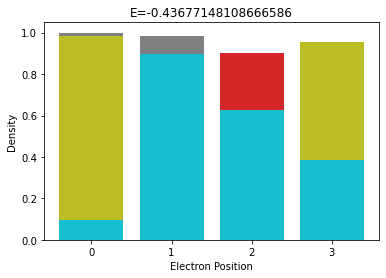

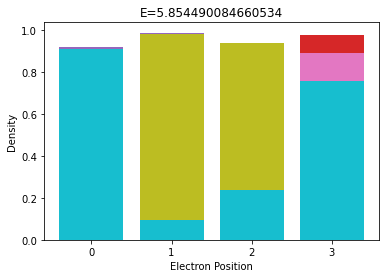

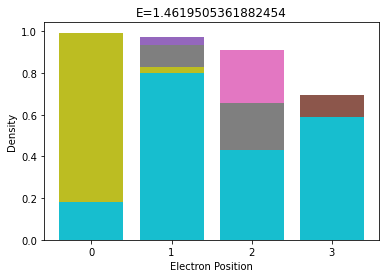

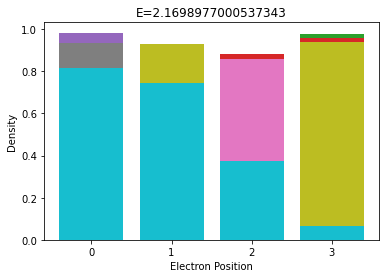

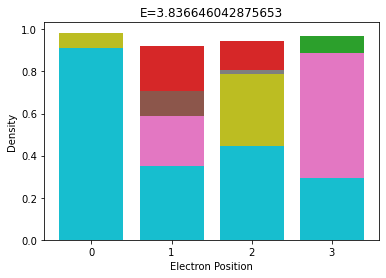

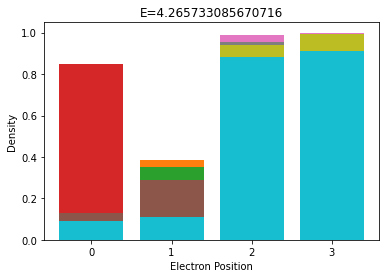

In [10]:
L = 4
N = 2
e_0 = 0
t=1
V=1
delta = 5

varience_list = []
for i in range(10):
    energies = [e_0+uniform(-1 * delta, delta) for i in range(L)]
    m, d, eig_vec = int_run_system(L=L, N=N, on_site_energies=energies, t=t, V=V, is_chain=True)
    varience_list.append(np.var(d))
    
sum(varience_list) / len(varience_list)


In [ ]:
'''
delta
10 = 0.2135334409594596
5 = 0.1731604814878879
2 = 0.0695499728977588
1 = 0.04261054532667621
0.1 = 0.034826548741394237
0.01 = 0.03535104028564018
'''

V 0.0 [-0.17407766 -0.52223297 -0.52223297 -0.34815531 -0.52223297 -0.17407766]
Matrix sum 1.9999999999999996
V 4.618033988749901 [ 0.27990313 -0.45289278  0.3459793   0.55980626 -0.45289278  0.27990313]
Matrix sum 2.0
V 1.3819660112501049 [-3.71748034e-01 -6.01500955e-01  1.16159151e-16 -3.96897283e-16
  6.01500955e-01  3.71748034e-01]
Matrix sum 2.0
V 3.618033988749893 [-6.01500955e-01  3.71748034e-01  4.46289432e-16  1.49935830e-16
 -3.71748034e-01  6.01500955e-01]
Matrix sum 2.0
V 3.0000000000000018 [ 5.77350269e-01  3.30129415e-16 -7.43563059e-16 -5.77350269e-01
  4.37162284e-16  5.77350269e-01]
Matrix sum 1.9999999999999998
V 2.3819660112501055 [-0.240869   -0.14886523  0.77946844 -0.48173799 -0.14886523 -0.240869  ]
Matrix sum 2.0


array([-0.03030303, -0.81818182, -0.54545455, -0.24242424, -0.81818182,
       -0.03030303])

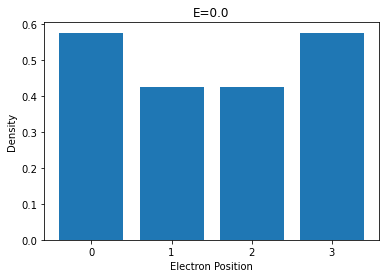

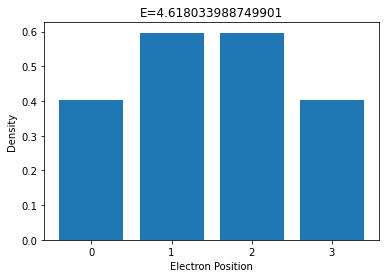

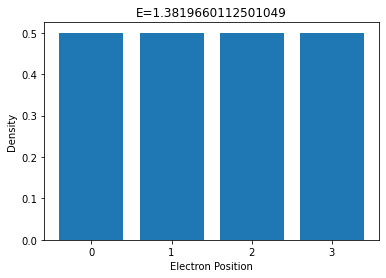

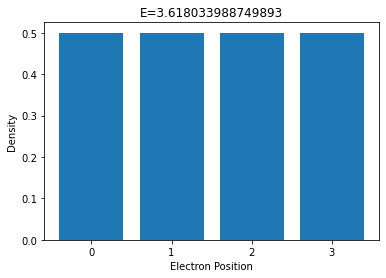

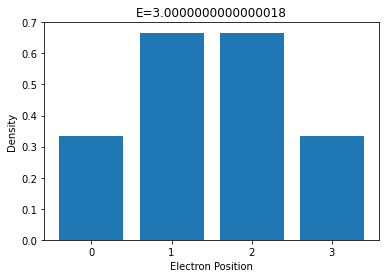

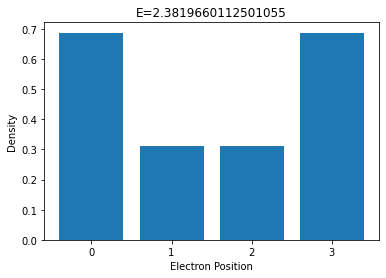

In [13]:
# Ground state

L = 4
N = 2
t=1
V=1
energies = [1 for i in range(L)]

m, d, eig_vec = int_run_system(L=L, N=N, on_site_energies=energies, t=t, V=V, is_chain=True)
eig_vec
'''
array([-0.17407766, -0.52223297, -0.52223297, -0.34815531, -0.52223297,
       -0.17407766])
       
prob array([0.03030303, 0.27272727, 0.27272727, 0.12121212, 0.27272727,
       0.03030303])
       
onsite_energies = array([0.06060606, 0.54545455, 0.54545455, 0.24242424, 0.54545455,
       0.06060606])
       
interationn = array([0.03030303, 0.        , 0.        , 0.12121212, 0.        ,
       0.03030303])
       
       
On_site_energy = 2
interationc_energy = 0.18181818330334729

transfer = -2.4848485028247107

       
E = 0
'''

a = np.array([-0.17407766, -0.52223297, -0.52223297, -0.34815531, -0.52223297,
       -0.17407766])

probs = a**2



# 3 => 1
# 5 => 3
# 9 => 2
# 6 => 2
# 10 => 3
# 12 => 1

transfer_energies = probs

transfer_energies[0] *= -1
transfer_energies[1] *= -3
transfer_energies[2] *= -2
transfer_energies[3] *= -2
transfer_energies[4] *= -3
transfer_energies[5] *= -1

np.sum(transfer_energies)
'''

interaction_energies = probs

interaction_energies[0] *= 1
interaction_energies[1] *= 0
interaction_energies[2] *= 0
interaction_energies[3] *= 1
interaction_energies[4] *= 0
interaction_energies[5] *= 1

np.sum(interaction_energies)
'''
transfer_energies

In [ ]:
states = generate_permutations(L,N, True)
states

for state in states:
    print(state,bin_array(state, L)[::-1])

In [ ]:
# First excited state
L = 4
N = 2
t=1
V=1
energies = [1 for i in range(L)]
m = int_generate_hamiltonian_matrix(L=L, N=N, on_site_energies=energies, t=t, V=V, is_chain=True)
w, v = LA.eig(m)
first_eig_val = w[2]
first_eig_vec = v[:,2]

print("first E =", first_eig_val)

'''

E = 1.38

onsite = 2
Interation = 0.28
transfer = -2.44

'''

probs = first_eig_vec**2

'''
onsite = probs * 2
np.sum(onsite)
'''

'''
interaction_energies = probs

interaction_energies[0] *= 1
interaction_energies[1] *= 0
interaction_energies[2] *= 0
interaction_energies[3] *= 1
interaction_energies[4] *= 0
interaction_energies[5] *= 1

np.sum(interaction_energies)
'''

transfer_energies = probs

transfer_energies[0] *= -1
transfer_energies[1] *= -3
transfer_energies[2] *= -2
transfer_energies[3] *= -2
transfer_energies[4] *= -3
transfer_energies[5] *= -1

np.sum(transfer_energies)
m

In [ ]:
# Ground state - ring
L = 4
N = 2
t=1
V=1
energies = [1 for i in range(L)]

m, d, eig_vec = int_run_system(L=L, N=N, on_site_energies=energies, t=t, V=V, is_chain=False)
eig_vec

'''

E = 0.43

onsite = 2
Interation = 0.3787321874818337
transfer = -1.9246943588890588

'''

probs = eig_vec**2

'''
onsite = probs * 2
np.sum(onsite)
'''

'''
interaction_energies = probs

interaction_energies[0] *= 1
interaction_energies[1] *= 0
interaction_energies[2] *= 1
interaction_energies[3] *= 1
interaction_energies[4] *= 0
interaction_energies[5] *= 1

np.sum(interaction_energies)
'''


transfer_energies = probs

transfer_energies[0] *= 0
transfer_energies[1] *= -2
transfer_energies[2] *= -2
transfer_energies[3] *= -2
transfer_energies[4] *= -2
transfer_energies[5] *= -0

np.sum(transfer_energies)




In [ ]:
2 + 0.3787321874818337 -1.9246943588890588

In [ ]:
# Ground state - using proper transfer terms 
L = 4
N = 2
t=1
V=1
energies = [1 for i in range(L)]
states = generate_permutations(L,N, True)

m, d, eig_vec = int_run_system(L=L, N=N, on_site_energies=energies, t=t, V=V, is_chain=True)
print(eig_vec)

'''
E_tot = 0
E_onsite = 2
E_int = 0.18181818181818174
E_transfer = -2.181818181818181
'''

diagonal_probs = eig_vec**2

#onsite = diagonal_probs * 2
#np.sum(onsite)

'''
interaction_energies = diagonal_probs

interaction_energies[0] *= 1
interaction_energies[1] *= 0
interaction_energies[2] *= 0
interaction_energies[3] *= 1
interaction_energies[4] *= 0
interaction_energies[5] *= 1

np.sum(interaction_energies)
'''

result = np.zeros((6,6))

for i, val_1 in enumerate(eig_vec):
    for j, val_2 in enumerate(eig_vec):
        result[i][j] = val_1 * val_2
        
transfer_m = int_generate_transfer_energy(states,L, t=t)

total_ke = transfer_m * result

np.sum(total_ke)

result

In [ ]:
def getProbabilityMatrix(eig_vec):
    return np.outer(eig_vec, eig_vec)
    
getProbabilityMatrix(eig_vec)

In [ ]:
L = 4
N = 2
t=1
V=1
energies = [1 for i in range(L)]
states = generate_permutations(L,N, True)

transfer_m = int_generate_transfer_energy(states,L, t=t)
on_site_m = int_generate_on_site_energy(states, L, energies=energies)
interaction_m = int_generate_interaction_energy(states, L, V=V)

print("t", transfer_m)
print("on site", on_site_m)
print("int", interaction_m)


prob_m = getProbabilityMatrix(eig_vec)
print(prob_m)

print("After")

print("t", transfer_m*prob_m)
print("on site", on_site_m*prob_m)
print("int", interaction_m*prob_m)

t_sum = np.sum(transfer_m*prob_m)
on_site_sum = np.sum(on_site_m*prob_m)
interaction_sum = np.sum(interaction_m*prob_m)

print(t_sum+on_site_sum+interaction_sum)

In [ ]:
# First excited state
L = 4
N = 2
t=1
V=1
energies = [1 for i in range(L)]
m = int_generate_hamiltonian_matrix(L=L, N=N, on_site_energies=energies, t=t, V=V, is_chain=True)
w, v = LA.eig(m)
first_eig_val = w[2]
first_eig_vec = v[:,2]

print("first E =", first_eig_val)

eig_vec = first_eig_vec


states = generate_permutations(L,N, True)

transfer_m = int_generate_transfer_energy(states,L, t=t)
on_site_m = int_generate_on_site_energy(states, L, energies=energies)
interaction_m = int_generate_interaction_energy(states, L, V=V)

print("t", transfer_m)
print("on site", on_site_m)
print("int", interaction_m)


prob_m = getProbabilityMatrix(eig_vec)
print(prob_m)

print("After")

print("t", transfer_m*prob_m)
print("on site", on_site_m*prob_m)
print("int", interaction_m*prob_m)

t_sum = np.sum(transfer_m*prob_m)
on_site_sum = np.sum(on_site_m*prob_m)
interaction_sum = np.sum(interaction_m*prob_m)

print(t_sum+on_site_sum+interaction_sum)

In [3]:
def generateTrainingData(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    states = generate_permutations(L,N, True)
    transfer_m = []
    on_site_m = []
    interaction_m = []
    if is_chain:
        transfer_m = int_generate_transfer_energy(states,L, t=t)
        on_site_m = int_generate_on_site_energy(states, L, energies=on_site_energies)
        interaction_m = int_generate_interaction_energy(states, L, V=V)
    else:
        transfer_m = ring_generate_transfer_energy(states,L, t=t)
        on_site_m = int_generate_on_site_energy(states, L, energies=on_site_energies)
        interaction_m = ring_generate_interaction_energy(states, L, V=V)
        
    m = transfer_m + on_site_m + interaction_m
    
    eig_results = eigh(m,subset_by_index=[0,1])
    
    result = [0,0]
    
    for i in range(2):
        eig_val = eig_results[0][i]
        eig_vec = eig_results[1][:,i]
        
        densities = int_get_electron_density(states,L,eig_vec)
    
        prob_m = getProbabilityMatrix(eig_vec)
    
        t_sum = np.sum(transfer_m*prob_m)
        on_site_sum = np.sum(on_site_m*prob_m)
        interaction_sum = np.sum(interaction_m*prob_m)
    
        result_dict = {
            "wave_function": eig_vec,
            "densities": densities,
            "total_energy": eig_val,
            "hopping_energy": t_sum,
            "onsite_energy": on_site_sum,
            "interaction_energy": interaction_sum
        }
        
        result[i] = result_dict
    
    return result
    
        

In [4]:
generateTrainingData(L=4, N=2, on_site_energies=[1,1,1,1], t=1, V=1, is_chain=True)

[{'wave_function': array([-0.17407766, -0.52223297, -0.52223297, -0.34815531, -0.52223297,
         -0.17407766]),
  'densities': array([0.57575758, 0.42424242, 0.42424242, 0.57575758]),
  'total_energy': 3.865734404318223e-17,
  'hopping_energy': -2.1818181818181817,
  'onsite_energy': 1.9999999999999998,
  'interaction_energy': 0.1818181818181818},
 {'wave_function': array([ 3.71748034e-01,  6.01500955e-01, -2.94822415e-16,  1.31685308e-16,
         -6.01500955e-01, -3.71748034e-01]),
  'densities': array([0.5, 0.5, 0.5, 0.5]),
  'total_energy': 1.3819660112501055,
  'hopping_energy': -0.8944271909999156,
  'onsite_energy': 1.9999999999999993,
  'interaction_energy': 0.276393202250021}]

In [ ]:
dummy_array = np.array([[1,0],[0,1]])
eigh(dummy_array)

In [ ]:
def testEigh(L=4, N=2, on_site_energies=[0,0,0,0], t=0, V=0, is_chain=True):
    states = generate_permutations(L,N, True)
    transfer_m = []
    on_site_m = []
    interaction_m = []
    if is_chain:
        transfer_m = int_generate_transfer_energy(states,L, t=t)
        on_site_m = int_generate_on_site_energy(states, L, energies=on_site_energies)
        interaction_m = int_generate_interaction_energy(states, L, V=V)
    else:
        transfer_m = ring_generate_transfer_energy(states,L, t=t)
        on_site_m = int_generate_on_site_energy(states, L, energies=on_site_energies)
        interaction_m = ring_generate_interaction_energy(states, L, V=V)
        
    m = transfer_m + on_site_m + interaction_m
    
    return eigh(m,subset_by_index=[0,1])

In [ ]:
result = testEigh(L=4, N=2, on_site_energies=[1,1,1,1], t=1, V=1, is_chain=True)

In [ ]:
result[1][:,1]

In [19]:
result_ground_df = pd.DataFrame(columns={'wave_function', 'densities', 'total_energy','hopping_energy','onsite_energy','interaction_energy'})
result_first_df = pd.DataFrame(columns={'wave_function', 'densities', 'total_energy','hopping_energy','onsite_energy','interaction_energy'})


for i in range(1000):
    if i % 10 == 0:
        print(i)
    result = generateTrainingData(L=4, N=2, on_site_energies=[1,1,1,1], t=1, V=1, is_chain=True)
    result_ground_df = result_ground_df.append(result[0],ignore_index=True)
    result_first_df = result_first_df.append(result[1],ignore_index=True)
    
print("Fin")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Fin


In [20]:
result_ground_df.to_csv("data_4_2_ground.csv", encoding='utf-8', index=False)
result_first_df.to_csv("data_4_2_first.csv", encoding='utf-8', index=False)

In [36]:
sample_df = pd.DataFrame(columns={'wave_function', 'densities', 'total_energy','hopping_energy','onsite_energy','interaction_energy'})
sample_df

,onsite_energy,total_energy,wave_function,hopping_energy,densities,interaction_energy


In [42]:
a = {'wave_function': [-0.17407766, -0.52223297, -0.52223297, -0.34815531, -0.52223297,
         -0.17407766],
  'densities': [0.57575758, 0.42424242, 0.42424242, 0.57575758],
  'total_energy': 3.865734404318223e-17,
  'hopping_energy': -2.1818181818181817,
  'onsite_energy': 1.9999999999999998,
  'interaction_energy': 0.1818181818181818}

sample_df = sample_df.append(a,ignore_index=True)

sample_df

,onsite_energy,total_energy,wave_function,hopping_energy,densities,interaction_energy
0,2.0,3.865734e-17,"[-0.17407766, -0.52223297, -0.52223297, -0.348...",-2.181818,"[0.57575758, 0.42424242, 0.42424242, 0.57575758]",0.181818
1,2.0,3.865734e-17,"[-0.17407766, -0.52223297, -0.52223297, -0.348...",-2.181818,"[0.57575758, 0.42424242, 0.42424242, 0.57575758]",0.181818
2,2.0,3.865734e-17,"[-0.17407766, -0.52223297, -0.52223297, -0.348...",-2.181818,"[0.57575758, 0.42424242, 0.42424242, 0.57575758]",0.181818
3,2.0,3.865734e-17,"[-0.17407766, -0.52223297, -0.52223297, -0.348...",-2.181818,"[0.57575758, 0.42424242, 0.42424242, 0.57575758]",0.181818
4,2.0,3.865734e-17,"[-0.17407766, -0.52223297, -0.52223297, -0.348...",-2.181818,"[0.57575758, 0.42424242, 0.42424242, 0.57575758]",0.181818
5,2.0,3.865734e-17,"[-0.17407766, -0.52223297, -0.52223297, -0.348...",-2.181818,"[0.57575758, 0.42424242, 0.42424242, 0.57575758]",0.181818


In [43]:
sample_df.to_csv("sample.csv", encoding='utf-8', index=False)

In [44]:
data_df = pd.read_csv("sample.csv") 

In [53]:
import ast
x = data_df['wave_function'][0]
ast.literal_eval(x)[0]

-0.17407766

In [58]:
np.random.uniform(-1,0,10)

array([-0.22736314, -0.88875722, -0.95103947, -0.13105328, -0.26716796,
       -0.93242822, -0.20664146, -0.14045912, -0.21228058, -0.86180532])

In [74]:
res = str(0.001).replace(".", "")
res

'0001'

In [78]:
def getDeltaString(input_val):
    return str(input_val).replace(".", "")

getDeltaString(1)

'1'

In [100]:
# L N type V T

data_columns = {'wave_function', 'densities', 'total_energy','hopping_energy','onsite_energy','interaction_energy','onsite_energies'}

result_ground_df = pd.DataFrame(columns=data_columns)
result_first_df = pd.DataFrame(columns=data_columns)

L = 10
N = 5

is_chains = [True, False]
Vs = [1,4,6]
deltas = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 3]

num_of_data_points = 750

for is_chain in is_chains:
    data_type = "chain"
    if is_chain == False:
        data_type = "ring"
    for V in Vs:
        for delta in deltas:
            file_name_prefix = "data/" + str(L) + "_" + str(N) + "_" + data_type + "_" + str(V) + "_" + getDeltaString(delta) + "_"
            print(file_name_prefix)
            result_ground_df = pd.DataFrame(columns=data_columns)
            result_first_df = pd.DataFrame(columns=data_columns)
            for i in range(num_of_data_points):
                if i % 100 == 0:
                    print(i)
                result = generateTrainingData(L=L, N=N, on_site_energies=list(np.random.uniform(-1*delta,delta,L)), t=1, V=V, is_chain=is_chain)
                result_ground_df = result_ground_df.append(result[0],ignore_index=True)
                result_first_df = result_first_df.append(result[1],ignore_index=True)
            result_ground_df.to_csv(file_name_prefix + "ground.csv", encoding='utf-8', index=False)
            result_first_df.to_csv(file_name_prefix + "first.csv", encoding='utf-8', index=False)
            

print("Fin")

# t always = 1
# V = 1,4,6 (directory for each one)
# os => delta = 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 3 (units of t), 500 points for each disorder, e_0=0, save input energies
# tensorflow (keras)

data/10_5_chain_1_0001_
0
100
200
300
400
500
600
700
data/10_5_chain_1_001_
0
100
200
300
400
500
600
700
data/10_5_chain_1_005_
0
100
200
300
400
500
600
700
data/10_5_chain_1_01_
0
100
200
300
400
500
600
700
data/10_5_chain_1_05_
0
100
200
300
400
500
600
700
data/10_5_chain_1_1_
0
100
200
300
400
500
600
700
data/10_5_chain_1_2_
0
100
200
300
400
500
600
700
data/10_5_chain_1_3_
0
100
200
300
400
500
600
700
data/10_5_chain_4_0001_
0
100
200
300
400
500
600
700
data/10_5_chain_4_001_
0
100
200
300
400
500
600
700
data/10_5_chain_4_005_
0
100
200
300
400
500
600
700
data/10_5_chain_4_01_
0
100
200
300
400
500
600
700
data/10_5_chain_4_05_
0
100
200
300
400
500
600
700
data/10_5_chain_4_1_
0
100
200
300
400
500
600
700
data/10_5_chain_4_2_
0
100
200
300
400
500
600
700
data/10_5_chain_4_3_
0
100
200
300
400
500
600
700
data/10_5_chain_6_0001_
0
100
200
300
400
500
600
700
data/10_5_chain_6_001_
0
100
200
300
400
500
600
700
data/10_5_chain_6_005_
0
100
200
300
400
500
600
700
data/1

In [6]:
import os
files = os.listdir("data/")
files
L = 4
structure = "chain"
V = 1
state = "ground"

['10_5_chain_1_0001_first.csv',
 '10_5_chain_1_0001_ground.csv',
 '10_5_chain_1_001_first.csv',
 '10_5_chain_1_001_ground.csv',
 '10_5_chain_1_005_first.csv',
 '10_5_chain_1_005_ground.csv',
 '10_5_chain_1_01_first.csv',
 '10_5_chain_1_01_ground.csv',
 '10_5_chain_1_05_first.csv',
 '10_5_chain_1_05_ground.csv',
 '10_5_chain_1_1_first.csv',
 '10_5_chain_1_1_ground.csv',
 '10_5_chain_1_2_first.csv',
 '10_5_chain_1_2_ground.csv',
 '10_5_chain_1_3_first.csv',
 '10_5_chain_1_3_ground.csv',
 '10_5_chain_4_0001_first.csv',
 '10_5_chain_4_0001_ground.csv',
 '10_5_chain_4_001_first.csv',
 '10_5_chain_4_001_ground.csv',
 '10_5_chain_4_005_first.csv',
 '10_5_chain_4_005_ground.csv',
 '10_5_chain_4_01_first.csv',
 '10_5_chain_4_01_ground.csv',
 '10_5_chain_4_05_first.csv',
 '10_5_chain_4_05_ground.csv',
 '10_5_chain_4_1_first.csv',
 '10_5_chain_4_1_ground.csv',
 '10_5_chain_4_2_first.csv',
 '10_5_chain_4_2_ground.csv',
 '10_5_chain_4_3_first.csv',
 '10_5_chain_4_3_ground.csv',
 '10_5_chain_6_0001_

In [25]:
def getFilenames(data_directory="data/", L=4, structure = "chain", V=1, state ="ground"):
    files = os.listdir(data_directory)
    result = []
    for filename in files:
        file_options = filename.split("_")
        if file_options[0] == str(L):
            if file_options[2] == structure:
                if file_options[3] == str(V):
                    if file_options[5] == state + ".csv":
                        result.append(filename)
    return result

In [35]:
getFilenames()

['4_2_chain_1_0001_ground.csv',
 '4_2_chain_1_001_ground.csv',
 '4_2_chain_1_005_ground.csv',
 '4_2_chain_1_01_ground.csv',
 '4_2_chain_1_05_ground.csv',
 '4_2_chain_1_1_ground.csv',
 '4_2_chain_1_2_ground.csv',
 '4_2_chain_1_3_ground.csv']

In [32]:
def getExtraFields(filename):
    file_options = filename.split("_")
    print(file_options)
    V = file_options[3]
    delta = file_options[4]
    delta_list = list(delta)
    if delta_list[0] == '0':
        delta_list.insert(1, ".")
    delta = ''.join(delta_list)
    return {"V":V, "delta":delta}

In [33]:
for filename in getFilenames():
    print(getExtraFields(filename))

['4', '2', 'chain', '1', '0001', 'ground.csv']
{'V': '1', 'delta': '0.001'}
['4', '2', 'chain', '1', '001', 'ground.csv']
{'V': '1', 'delta': '0.01'}
['4', '2', 'chain', '1', '005', 'ground.csv']
{'V': '1', 'delta': '0.05'}
['4', '2', 'chain', '1', '01', 'ground.csv']
{'V': '1', 'delta': '0.1'}
['4', '2', 'chain', '1', '05', 'ground.csv']
{'V': '1', 'delta': '0.5'}
['4', '2', 'chain', '1', '1', 'ground.csv']
{'V': '1', 'delta': '1'}
['4', '2', 'chain', '1', '2', 'ground.csv']
{'V': '1', 'delta': '2'}
['4', '2', 'chain', '1', '3', 'ground.csv']
{'V': '1', 'delta': '3'}


In [6]:
import csv

In [9]:
file = open('data/4_2_chain_1_0001_ground.csv')

In [11]:
csvreader = csv.reader(file)
header = []
header = next(csvreader)
header

['interaction_energy',
 'densities',
 'hopping_energy',
 'wave_function',
 'onsite_energies',
 'total_energy',
 'onsite_energy']

In [12]:
rows = []
for row in csvreader:
        rows.append(row)
rows

[['0.18186361965509296',
  '[0.57570858 0.42430663 0.42429047 0.57569432]',
  '-2.1818635960584594',
  '[-0.17410698 -0.52224524 -0.52216401 -0.34821308 -0.52224615 -0.1740633 ]',
  '[0.0004975980303850468, 0.00017243420711404397, -0.0002501129357917025, 0.00016216327779803794]',
  '-1.9996531156371653',
  '0.00034686076620236067'],
 ['0.18180652323536522',
  '[0.57541969 0.4245126  0.4239436  0.57612411]',
  '-2.181806212087264',
  '[-0.17397846 -0.52192489 -0.52225051 -0.34814048 -0.52253449 -0.17417297]',
  '[-8.269562310786102e-05, 0.0009927394488696635, -6.329020178833791e-05, 0.0008234712613153785]',
  '-1.9991794921675285',
  '0.0008201966843712777'],
 ['0.18171111980400034',
  '[0.57565708 0.42427428 0.42394602 0.57612262]',
  '-2.1817108770424185',
  '[-0.17396143 -0.52201291 -0.52239547 -0.34801915 -0.52239293 -0.17415858]',
  '[-0.0009470803776217287, 0.0004610518493864729, 0.00052950589444666, 0.00019939074997963116]',
  '-2.0000104941384556',
  '-1.0736900037327221e-05'],


In [42]:
def getFileData(filename, filedirectory="data/"):
    file = open(filedirectory + filename)
    csvreader = csv.reader(file)
    
    #extra_fields = getExtraFields(filename)
    #print(extra_fields)
    
    header = []
    header = next(csvreader)
    #header.append("V")
    #header.append("delta")
    
    rows = []
    for row in csvreader:
        #row.append(extra_fields["V"])
        #row.append(extra_fields["delta"])
        rows.append(row)
        
    return {"headers": header, "rows": rows}

In [44]:
data = getFileData("4_2_chain_1_0001_ground.csv")

In [45]:
data

{'headers': ['interaction_energy',
  'densities',
  'hopping_energy',
  'wave_function',
  'onsite_energies',
  'total_energy',
  'onsite_energy'],
 'rows': [['0.18186361965509296',
   '[0.57570858 0.42430663 0.42429047 0.57569432]',
   '-2.1818635960584594',
   '[-0.17410698 -0.52224524 -0.52216401 -0.34821308 -0.52224615 -0.1740633 ]',
   '[0.0004975980303850468, 0.00017243420711404397, -0.0002501129357917025, 0.00016216327779803794]',
   '-1.9996531156371653',
   '0.00034686076620236067'],
  ['0.18180652323536522',
   '[0.57541969 0.4245126  0.4239436  0.57612411]',
   '-2.181806212087264',
   '[-0.17397846 -0.52192489 -0.52225051 -0.34814048 -0.52253449 -0.17417297]',
   '[-8.269562310786102e-05, 0.0009927394488696635, -6.329020178833791e-05, 0.0008234712613153785]',
   '-1.9991794921675285',
   '0.0008201966843712777'],
  ['0.18171111980400034',
   '[0.57565708 0.42427428 0.42394602 0.57612262]',
   '-2.1817108770424185',
   '[-0.17396143 -0.52201291 -0.52239547 -0.34801915 -0.522

In [144]:
def splitData(data):
    #print(data["headers"])
    
    input_list = []
    output_list = []
    for row in data["rows"]:
        #int_energy = row[0]
        densities = formatDensities(row[1])
        #hop_energy = row[2]
        #wave_function = row[3]
        #onsite_energies = row[4]
        total_energy = float(row[5])
        onsite_energy = float(row[6])
        
        input_list.append(densities)
        
        output_energy = total_energy - onsite_energy
        output_list.append(output_energy)
        
    return {"input": input_list, "output": output_list}

In [145]:
splitData(data)

{'input': [[0.57570858, 0.42430663, 0.42429047, 0.57569432],
  [0.57541969, 0.4245126, 0.4239436, 0.57612411],
  [0.57565708, 0.42427428, 0.42394602, 0.57612262],
  [0.57547584, 0.42444679, 0.42420438, 0.575873],
  [0.57564277, 0.42435548, 0.4244168, 0.57558495],
  [0.57587594, 0.42415834, 0.42439939, 0.57556633],
  [0.57555422, 0.42434456, 0.42387368, 0.57622755],
  [0.57548311, 0.42445469, 0.4239097, 0.57615249],
  [0.57565876, 0.42431564, 0.42433073, 0.57569487],
  [0.57564344, 0.42435483, 0.42426174, 0.57573999],
  [0.57599568, 0.42402135, 0.42410647, 0.5758765],
  [0.57619649, 0.42386624, 0.424214, 0.57572327],
  [0.57583395, 0.42418667, 0.42444134, 0.57553805],
  [0.57572063, 0.42429453, 0.42429908, 0.57568576],
  [0.57567148, 0.4243517, 0.42433327, 0.57564356],
  [0.57582405, 0.4241375, 0.42413747, 0.57590098],
  [0.57613523, 0.42393686, 0.42445096, 0.57547694],
  [0.57613992, 0.42392162, 0.42449898, 0.57543948],
  [0.57608379, 0.42395976, 0.42444424, 0.57551221],
  [0.57599915,

In [141]:
def formatDensities(den):
    den = den.replace("[","")
    den = den.replace("]","")
    dots = getPositionOfCharacters(den, ".")
    starts = np.array(dots) - 1
    spaces = getPositionOfCharacters(den, " ")
    
    numbers = []
    
    for start in starts:
        end = getNextLargest(start, spaces)
        if end != 0:
            numbers.append(den[start:end])
        else:
            numbers.append(den[start:])
    
    
    return [float(i) for i in numbers]

In [139]:
den = '[0.57570858 0.42430663 0.42429047 0.57569432]'
formatDensities(den)

[0.57570858, 0.42430663, 0.42429047, 0.57569432]

In [132]:
def getPositionOfCharacters(s, c):
    return [pos for pos, char in enumerate(s) if char == c]

dots = getPositionOfCharacters(den, ".")
starts = np.array(dots) - 1
spaces = getPositionOfCharacters(den, " ")

print(dots, starts, spaces)

[2, 13, 24, 35] [ 1 12 23 34] [11, 22, 33]


In [137]:
def getNextLargest(val, input_list):
    ans = 0
    for value in input_list:
        if val < value:
            ans = value 
            break
    return ans
            
getNextLargest(24, spaces)

33

In [138]:
def formatDensities(den):
    den = den.replace("[","")
    den = den.replace("]","")
    dots = getPositionOfCharacters(den, ".")
    starts = np.array(dots) - 1
    spaces = getPositionOfCharacters(den, " ")
    
    numbers = []
    
    for start in starts:
        end = getNextLargest(start, spaces)
        if end != 0:
            numbers.append(den[start:end])
        else:
            numbers.append(den[start:])
    
    
    return [float(i) for i in numbers]
    



In [140]:
den = '[0.57570858 0.42430663 0.42429047 0.57569432]'
formatDensities(den)

[0.57570858, 0.42430663, 0.42429047, 0.57569432]

In [146]:
formatted_data = splitData(data)

In [149]:
X = formatted_data['input']
y = formatted_data['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [155]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(4, )),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear')
])

In [164]:
model.compile(optimizer='adam',
              loss='mean_squared_error')

In [165]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
11/11 [==============================] - 0s 1ms/step - loss: 0.0311
Epoch 2/5
11/11 [==============================] - 0s 1ms/step - loss: 0.0327
Epoch 3/5
11/11 [==============================] - 0s 1ms/step - loss: 0.0300
Epoch 4/5
11/11 [==============================] - 0s 907us/step - loss: 0.0264
Epoch 5/5
11/11 [==============================] - 0s 975us/step - loss: 0.0260


In [166]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 814us/step - loss: 3.0181e-04


0.0003018080606125295

In [6]:
def runNNSystem(data_directory="data/", L=4, structure = "chain", V=1, state ="ground"):
    filenames = getFilenames(data_directory, L, structure, V, state)
    print(filenames)
    input_data = []
    output_data = []
    for filename in filenames:
        split_data = splitData(getFileData(filename),L)
        input_data.extend(split_data['input'])
        output_data.extend(split_data['output'])
        
    print("Length", len(input_data))
        
    x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.33)
    
    model = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(L, )),
          tf.keras.layers.Dense(250, activation='relu'),
          tf.keras.layers.Dense(20, activation='relu'),
          tf.keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
              loss='mean_squared_error')
    
    print(model.summary())
    
    print("Training", "L=" + str(L), "V=" + str(V), "structure=" + structure, "state=" + state)
    ans1 = model.fit(np.array(x_train), np.array(y_train), epochs=10,shuffle=True)#,validation_split=0.1)
    
    print("Evaluating")
    ans2 = model.evaluate(x_test, y_test)
    
    y_predict = model.predict(x_test)
    
    return (ans1,ans2,y_predict,y_test)

In [7]:
L = 4
structure = "chain"
V = 1
state = "ground"
result = runNNSystem(L=L, structure=structure, V=V, state=state)
plt.plot(result[0].history['loss'][1:])

y_pred = np.array(result[2])
y_test = np.array(result[3])

#y_diff = y_test - y_pred

y_pred

['4_2_chain_1_0001_ground.csv', '4_2_chain_1_001_ground.csv', '4_2_chain_1_005_ground.csv', '4_2_chain_1_01_ground.csv', '4_2_chain_1_05_ground.csv', '4_2_chain_1_1_ground.csv', '4_2_chain_1_2_ground.csv', '4_2_chain_1_3_ground.csv']


ValueError: could not convert string to float: '[0.0004967445639484831, 0.0005887495174274465, 0.00020655588829893807, -0.0008421424115489846]'

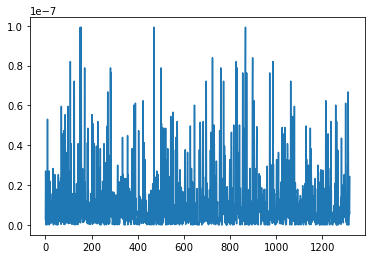

In [355]:
y_pred = np.array(result[2]).flatten()
y_test = np.array(result[3]).flatten()

y_diff = (y_test- y_pred)**2

#y_pred.shape(len(y_pred))

#plt.plot(y_diff)

#plt.plot(y_test, y_pred,'o')

#t = np.linspace(-4.5, 0.5, len(y_test))

plt.plot(y_diff)

In [6]:
from keras.utils.vis_utils import plot_model

L= 6

model = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(L, )),
          tf.keras.layers.Dense(250, activation='relu'),
          tf.keras.layers.Dense(20, activation='relu'),
          #tf.keras.layers.Dense(10, activation='relu'),
          #tf.keras.layers.Dropout(0.05),
          tf.keras.layers.Dense(1, activation='linear')
    ])

#print(model.summary())
    

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96,
    layer_range=None
)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [160]:
Ls = [4,6,8,10,12]
structures=["chain", "ring"]
Vs = [1,4,6]
states = ["ground","first"]

'''
Ls = [4]
structures=["chain"]
Vs = [1,4,6]
states = ["ground"]
'''

results = []

for state in states:
    for L in Ls:
        for structure in structures:
            for V in Vs:
                en = runNNSystem(L=L, structure=structure, V=V, state=state)
                results.append([state,L,structure,V,en])
        print(results)
                
print("Fin")

['4_2_chain_1_0001_ground.csv', '4_2_chain_1_001_ground.csv', '4_2_chain_1_005_ground.csv', '4_2_chain_1_01_ground.csv', '4_2_chain_1_05_ground.csv', '4_2_chain_1_1_ground.csv', '4_2_chain_1_2_ground.csv', '4_2_chain_1_3_ground.csv']
Training L=4 V=1 structure=chain state=ground
Epoch 1/10
377/377 [==============================] - 0s 602us/step - loss: 0.1747
Epoch 2/10
377/377 [==============================] - 0s 615us/step - loss: 0.0023
Epoch 3/10
377/377 [==============================] - 0s 603us/step - loss: 7.9613e-04
Epoch 4/10
377/377 [==============================] - 0s 616us/step - loss: 4.5261e-04
Epoch 5/10
377/377 [==============================] - 0s 575us/step - loss: 3.2074e-04
Epoch 6/10
377/377 [==============================] - 0s 662us/step - loss: 2.7033e-04
Epoch 7/10
377/377 [==============================] - 0s 631us/step - loss: 2.2365e-04
Epoch 8/10
377/377 [==============================] - 0s 606us/step - loss: 1.9454e-04
Epoch 9/10
377/377 [============

377/377 [==============================] - 0s 800us/step - loss: 0.0010
Epoch 10/10
377/377 [==============================] - 0s 740us/step - loss: 0.0011
Evaluating
186/186 [==============================] - 0s 644us/step - loss: 0.0010
['8_4_chain_4_0001_ground.csv', '8_4_chain_4_001_ground.csv', '8_4_chain_4_005_ground.csv', '8_4_chain_4_01_ground.csv', '8_4_chain_4_05_ground.csv', '8_4_chain_4_1_ground.csv', '8_4_chain_4_2_ground.csv', '8_4_chain_4_3_ground.csv']
Training L=8 V=4 structure=chain state=ground
Epoch 1/10
1047/1047 [==============================] - 1s 576us/step - loss: 0.2770
Epoch 2/10
1047/1047 [==============================] - 1s 751us/step - loss: 0.0439 0s - los
Epoch 3/10
1047/1047 [==============================] - 1s 980us/step - loss: 0.0397
Epoch 4/10
1047/1047 [==============================] - 1s 869us/step - loss: 0.0374
Epoch 5/10
1047/1047 [==============================] - 1s 776us/step - loss: 0.0363
Epoch 6/10
1047/1047 [=========================

377/377 [==============================] - 0s 1ms/step - loss: 0.0022
Evaluating
186/186 [==============================] - 0s 582us/step - loss: 0.0041
['10_5_chain_4_0001_ground.csv', '10_5_chain_4_001_ground.csv', '10_5_chain_4_005_ground.csv', '10_5_chain_4_01_ground.csv', '10_5_chain_4_05_ground.csv', '10_5_chain_4_1_ground.csv', '10_5_chain_4_2_ground.csv', '10_5_chain_4_3_ground.csv']
Training L=10 V=4 structure=chain state=ground
Epoch 1/10
1047/1047 [==============================] - 1s 563us/step - loss: 0.6485
Epoch 2/10
1047/1047 [==============================] - 1s 653us/step - loss: 0.0839
Epoch 3/10
1047/1047 [==============================] - 1s 824us/step - loss: 0.0737
Epoch 4/10
1047/1047 [==============================] - 1s 793us/step - loss: 0.0683
Epoch 5/10
1047/1047 [==============================] - 1s 795us/step - loss: 0.0647
Epoch 6/10
1047/1047 [==============================] - 1s 822us/step - loss: 0.0636
Epoch 7/10
1047/1047 [==========================

Epoch 1/10
377/377 [==============================] - 1s 923us/step - loss: 0.0183
Epoch 2/10
377/377 [==============================] - 0s 705us/step - loss: 0.0033
Epoch 3/10
377/377 [==============================] - 0s 803us/step - loss: 0.0031
Epoch 4/10
377/377 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 5/10
377/377 [==============================] - 0s 785us/step - loss: 0.0028
Epoch 6/10
377/377 [==============================] - 0s 811us/step - loss: 0.0028
Epoch 7/10
377/377 [==============================] - 0s 857us/step - loss: 0.0027
Epoch 8/10
377/377 [==============================] - 0s 856us/step - loss: 0.0028 0s - loss: 0
Epoch 9/10
377/377 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 10/10
377/377 [==============================] - 0s 778us/step - loss: 0.0026
Evaluating
186/186 [==============================] - 0s 623us/step - loss: 0.0026
['4_2_chain_4_0001_first.csv', '4_2_chain_4_001_first.csv', '4_2_chain_4_005_

Training L=6 V=1 structure=chain state=first
Epoch 1/10
377/377 [==============================] - 0s 568us/step - loss: 0.1449
Epoch 2/10
377/377 [==============================] - 0s 536us/step - loss: 0.0075
Epoch 3/10
377/377 [==============================] - 0s 682us/step - loss: 0.0057
Epoch 4/10
377/377 [==============================] - 0s 612us/step - loss: 0.0052
Epoch 5/10
377/377 [==============================] - 0s 617us/step - loss: 0.0050
Epoch 6/10
377/377 [==============================] - 0s 598us/step - loss: 0.0052
Epoch 7/10
377/377 [==============================] - 0s 573us/step - loss: 0.0050
Epoch 8/10
377/377 [==============================] - 0s 540us/step - loss: 0.0048
Epoch 9/10
377/377 [==============================] - 0s 584us/step - loss: 0.0047
Epoch 10/10
377/377 [==============================] - 0s 724us/step - loss: 0.0048
Evaluating
186/186 [==============================] - 0s 495us/step - loss: 0.0050
['6_3_chain_4_0001_first.csv', '6_3_chain

Training L=8 V=1 structure=chain state=first
Epoch 1/10
377/377 [==============================] - 0s 605us/step - loss: 0.3745
Epoch 2/10
377/377 [==============================] - 0s 931us/step - loss: 0.0147
Epoch 3/10
377/377 [==============================] - 0s 758us/step - loss: 0.0096
Epoch 4/10
377/377 [==============================] - 0s 838us/step - loss: 0.0075
Epoch 5/10
377/377 [==============================] - 0s 970us/step - loss: 0.0067
Epoch 6/10
377/377 [==============================] - 0s 864us/step - loss: 0.0063
Epoch 7/10
377/377 [==============================] - 0s 755us/step - loss: 0.0060
Epoch 8/10
377/377 [==============================] - 0s 838us/step - loss: 0.0060
Epoch 9/10
377/377 [==============================] - 0s 880us/step - loss: 0.0060
Epoch 10/10
377/377 [==============================] - 0s 948us/step - loss: 0.0057
Evaluating
186/186 [==============================] - 0s 521us/step - loss: 0.0076
['8_4_chain_4_0001_first.csv', '8_4_chain

Training L=10 V=1 structure=chain state=first
Epoch 1/10
377/377 [==============================] - 0s 669us/step - loss: 0.6990
Epoch 2/10
377/377 [==============================] - 0s 990us/step - loss: 0.0203
Epoch 3/10
377/377 [==============================] - 0s 867us/step - loss: 0.0126
Epoch 4/10
377/377 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 5/10
377/377 [==============================] - 0s 926us/step - loss: 0.0084
Epoch 6/10
377/377 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 7/10
377/377 [==============================] - 0s 945us/step - loss: 0.0073
Epoch 8/10
377/377 [==============================] - 0s 1ms/step - loss: 0.0072
Epoch 9/10
377/377 [==============================] - 0s 908us/step - loss: 0.0065
Epoch 10/10
377/377 [==============================] - 0s 1ms/step - loss: 0.0068
Evaluating
186/186 [==============================] - 0s 699us/step - loss: 0.0082
['10_5_chain_4_0001_first.csv', '10_5_chain_4_00

Training L=12 V=1 structure=chain state=first
Epoch 1/10
377/377 [==============================] - 0s 623us/step - loss: 1.3761
Epoch 2/10
377/377 [==============================] - 0s 852us/step - loss: 0.0376
Epoch 3/10
377/377 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 4/10
377/377 [==============================] - 0s 1ms/step - loss: 0.0157
Epoch 5/10
377/377 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 6/10
377/377 [==============================] - 0s 861us/step - loss: 0.0107
Epoch 7/10
377/377 [==============================] - 0s 931us/step - loss: 0.0092
Epoch 8/10
377/377 [==============================] - 0s 928us/step - loss: 0.0082
Epoch 9/10
377/377 [==============================] - 0s 938us/step - loss: 0.0079
Epoch 10/10
377/377 [==============================] - 0s 944us/step - loss: 0.0076
Evaluating
186/186 [==============================] - 0s 683us/step - loss: 0.0083
['12_6_chain_4_0001_first.csv', '12_6_chain_4_

In [163]:
dummy_results = results
dummy_results

[['ground', 4, 'chain', 1, 0.0001124022965086624],
 ['ground', 4, 'chain', 4, 0.004150056745857],
 ['ground', 4, 'chain', 6, 0.007480937521904707],
 ['ground', 4, 'ring', 1, 0.008481927216053009],
 ['ground', 4, 'ring', 4, 0.011805621907114983],
 ['ground', 4, 'ring', 6, 0.015935909003019333],
 ['ground', 6, 'chain', 1, 0.0005133175873197615],
 ['ground', 6, 'chain', 4, 0.013703598640859127],
 ['ground', 6, 'chain', 6, 0.02701234072446823],
 ['ground', 6, 'ring', 1, 0.03241842985153198],
 ['ground', 6, 'ring', 4, 0.15362659096717834],
 ['ground', 6, 'ring', 6, 0.24452628195285797],
 ['ground', 8, 'chain', 1, 0.0010115643963217735],
 ['ground', 8, 'chain', 4, 0.033904969692230225],
 ['ground', 8, 'chain', 6, 0.06692347675561905],
 ['ground', 8, 'ring', 1, 0.065151646733284],
 ['ground', 8, 'ring', 4, 0.0646687000989914],
 ['ground', 8, 'ring', 6, 0.09136498719453812],
 ['ground', 10, 'chain', 1, 0.004138067830353975],
 ['ground', 10, 'chain', 4, 0.06133882328867912],
 ['ground', 10, 'ch

In [164]:
df = pd.DataFrame(dummy_results, columns =['state', 'L', 'structure', 'V', 'Energy'], dtype = float)
df

,state,L,structure,V,Energy
0,ground,4.0,chain,1.0,0.000112
1,ground,4.0,chain,4.0,0.004150
2,ground,4.0,chain,6.0,0.007481
3,ground,4.0,ring,1.0,0.008482
4,ground,4.0,ring,4.0,0.011806
5,ground,4.0,ring,6.0,0.015936
6,ground,6.0,chain,1.0,0.000513
7,ground,6.0,chain,4.0,0.013704
8,ground,6.0,chain,6.0,0.027012
9,ground,6.0,ring,1.0,0.032418


In [165]:
df.to_csv("data/results/nn_250_20.csv", encoding='utf-8', index=False)

In [56]:
# L = 4, V = 1, struct=chain, state=ground, epoch = 10
# 128 neuron layer (dropout=0.2) => loss=0.000681
# 64 neuron layer => 0.0017
# 2*64 neuron layers => 0.0015
# 128 neuron layer (no dropout) => 0.000256
# 200 neuron layer (no dropout) => 0.000233
# 250 neuron layer (no dropout) => 0.000189
# (250 neuron) > (20 neuron)   => 0.0000829 
# (250 neuron) > (20 neuron) > (10 neuron) => 0.0000637 
# batch size = 10 => 0.000326
# batch size = 20,50,100 not effective 
# epoch = 15 less effective
# epoch = 12 => 0.0000667 

# for larger systems pure (250 neuron) layer is the most consistent 

In [182]:
# For (250 neuron) layer losses

twofifty_result = [
list(("ground",4,"chain",1,0.000186)),
list(("ground",4,"chain",4,0.0046)),
list(("ground",4,"chain",6,0.0077)),
list(("ground",4,"ring",1,0.0091)),
list(("ground",4,"ring",4,0.0177)),
list(("ground",4,"ring",6,0.0173)),
list(("ground",6,"chain",1,0.000704)),
list(("ground",6,"chain",4,0.0156)),
list(("ground",6,"chain",6,0.0314)),
list(("ground",6,"ring",1,0.0316)),
list(("ground",6,"ring",4,0.1745)),
list(("ground",6,"ring",6,0.2870)),
list(("ground",8,"chain",1,0.0036)),
list(("ground",8,"chain",4,0.0330)),
list(("ground",8,"chain",6,0.0675)),
list(("ground",8,"ring",1,0.0655)),
list(("ground",8,"ring",4,0.0741)),
list(("ground",8,"ring",6,0.1009)),
list(("ground",10,"chain",1,0.006)),
list(("ground",10,"chain",4,0.0603)),
list(("ground",10,"chain",6,0.118)),
list(("ground",10,"ring",1,0.1126)),
list(("ground",10,"ring",4,0.4984)),
list(("ground",10,"ring",6,0.7138)),
list(("ground",12,"chain",1,0.0052)),
list(("ground",12,"chain",4,0.1035)),
list(("ground",12,"chain",6,0.1699)),
list(("ground",12,"ring",1,0.1567)),
list(("ground",12,"ring",4,0.1689)),
list(("ground",12,"ring",6,0.2157)),
list(("first",4,"chain",1,0.0029)),
list(("first",4,"chain",4,0.0345)),
list(("first",4,"chain",6,0.0418)),
list(("first",4,"ring",1,0.0611)),
list(("first",4,"ring",4,0.0744)),
list(("first",4,"ring",6,0.0683)),
list(("first",6,"chain",1,0.0048)),
list(("first",6,"chain",4,0.0456)),
list(("first",6,"chain",6,0.0791)),
list(("first",6,"ring",1,0.0686)),
list(("first",6,"ring",4,0.0889)),
list(("first",6,"ring",6,0.1407)),
list(("first",8,"chain",1,0.0065)),
list(("first",8,"chain",4,0.0772)),
list(("first",8,"chain",6,0.1374)),
list(("first",8,"ring",1,0.1548)),
list(("first",8,"ring",4,0.177)),
list(("first",8,"ring",6,0.2793)),
list(("first",10,"chain",1,0.0107)),
list(("first",10,"chain",4,0.1170)),
list(("first",10,"chain",6,0.2319)),
list(("first",10,"ring",1,0.2333)),
list(("first",10,"ring",4,0.4100)),
list(("first",10,"ring",6,0.5649)),
list(("first",12,"chain",1,0.0153)),
list(("first",12,"chain",4,0.1803)),
list(("first",12,"chain",6,0.2759)),
list(("first",12,"ring",1,0.2843)),
list(("first",12,"ring",4,0.3387)),
list(("first",12,"ring",6,0.4663))]


# check returning history 

twofif_df = pd.DataFrame(twofifty_result, columns =['state', 'L', 'structure', 'V', 'Energy'], dtype = float)
twofif_df.to_csv("data/results/nn_250.csv", encoding='utf-8', index=False)
twofif_df

,state,L,structure,V,Energy
0,ground,4.0,chain,1.0,0.000186
1,ground,4.0,chain,4.0,0.004600
2,ground,4.0,chain,6.0,0.007700
3,ground,4.0,ring,1.0,0.009100
4,ground,4.0,ring,4.0,0.017700
5,ground,4.0,ring,6.0,0.017300
6,ground,6.0,chain,1.0,0.000704
7,ground,6.0,chain,4.0,0.015600
8,ground,6.0,chain,6.0,0.031400
9,ground,6.0,ring,1.0,0.031600


In [177]:
a = [list(("ground",4,"chain",4))]
a

[['ground', 4, 'chain', 4]]

In [192]:
two_layer_df = df
one_layer_df = twofif_df

tl_energies = two_layer_df["Energy"]
ol_energies = one_layer_df["Energy"]

energy_results = []
for i, ol_en in enumerate(ol_energies):
    print(i, ol_en-tl_energies[i])
    
    if ol_en<tl_energies[i]:
        energy_results.append(1)
    else:
        energy_results.append(2)
        
energy_results

print("Results", energy_results.count(1), energy_results.count(2))

# 6 vs 52 for 250 vs 250-20

0 7.359770349133759e-05
1 0.00044994325414299957
2 0.0002190624780952933
3 0.0006180727839469914
4 0.005894378092885018
5 0.0013640909969806665
6 0.00019068241268023847
7 0.0018964013591408722
8 0.004387659275531766
9 -0.0008184298515319793
10 0.020873409032821644
11 0.042473718047142006
12 0.0025884356036782264
13 -0.0009049696922302231
14 0.0005765232443809554
15 0.0003483532667160061
16 0.009431299901008605
17 0.009535012805461887
18 0.0018619321696460248
19 -0.0010388232886791235
20 0.0021791450977325377
21 0.005206228590011602
22 0.07255756583213807
23 0.09360014085769652
24 0.0011694170393049715
25 0.013949393093585963
26 0.02807828774452209
27 0.019434749913215643
28 0.016309471869468684
29 0.03205169684886933
30 0.0002598932847380636
31 0.004030429691076282
32 0.002311513054370877
33 0.002980356520414354
34 0.0061909106612205445
35 0.006355139034986496
36 -0.00024018692299723667
37 0.0032667957007884996
38 0.004141049718856815
39 0.004950509524345392
40 0.007298648500442512
41 

In [199]:
df = pd.read_csv("data/results/nn_250_20.csv")
df

,state,L,structure,V,Loss
0,ground,4.0,chain,1.0,0.000112
1,ground,4.0,chain,4.0,0.004150
2,ground,4.0,chain,6.0,0.007481
3,ground,4.0,ring,1.0,0.008482
4,ground,4.0,ring,4.0,0.011806
5,ground,4.0,ring,6.0,0.015936
6,ground,6.0,chain,1.0,0.000513
7,ground,6.0,chain,4.0,0.013704
8,ground,6.0,chain,6.0,0.027012
9,ground,6.0,ring,1.0,0.032418


In [330]:
# how many params a model has

In [339]:
filename = "4_2_chain_4_0001_ground.csv"
df = pd.read_csv("data/all_data/" + filename)
cut_df = df[:500]
cut_df.to_csv("data/"+filename, encoding='utf-8', index=False)

In [343]:
files = os.listdir("data/all_data")
for filename in files:
    print(filename)
    df = pd.read_csv("data/all_data/" + filename)
    cut_df = df[:500]
    cut_df.to_csv("data/"+filename, encoding='utf-8', index=False)

10_5_chain_1_0001_first.csv
10_5_chain_1_0001_ground.csv
10_5_chain_1_001_first.csv
10_5_chain_1_001_ground.csv
10_5_chain_1_005_first.csv
10_5_chain_1_005_ground.csv
10_5_chain_1_01_first.csv
10_5_chain_1_01_ground.csv
10_5_chain_1_05_first.csv
10_5_chain_1_05_ground.csv
10_5_chain_1_1_first.csv
10_5_chain_1_1_ground.csv
10_5_chain_1_2_first.csv
10_5_chain_1_2_ground.csv
10_5_chain_1_3_first.csv
10_5_chain_1_3_ground.csv
10_5_chain_4_0001_first.csv
10_5_chain_4_0001_ground.csv
10_5_chain_4_001_first.csv
10_5_chain_4_001_ground.csv
10_5_chain_4_005_first.csv
10_5_chain_4_005_ground.csv
10_5_chain_4_01_first.csv
10_5_chain_4_01_ground.csv
10_5_chain_4_05_first.csv
10_5_chain_4_05_ground.csv
10_5_chain_4_1_first.csv
10_5_chain_4_1_ground.csv
10_5_chain_4_2_first.csv
10_5_chain_4_2_ground.csv
10_5_chain_4_3_first.csv
10_5_chain_4_3_ground.csv
10_5_chain_6_0001_first.csv
10_5_chain_6_0001_ground.csv
10_5_chain_6_001_first.csv
10_5_chain_6_001_ground.csv
10_5_chain_6_005_first.csv
10_5_chai

6_3_chain_6_0001_first.csv
6_3_chain_6_0001_ground.csv
6_3_chain_6_001_first.csv
6_3_chain_6_001_ground.csv
6_3_chain_6_005_first.csv
6_3_chain_6_005_ground.csv
6_3_chain_6_01_first.csv
6_3_chain_6_01_ground.csv
6_3_chain_6_05_first.csv
6_3_chain_6_05_ground.csv
6_3_chain_6_1_first.csv
6_3_chain_6_1_ground.csv
6_3_chain_6_2_first.csv
6_3_chain_6_2_ground.csv
6_3_chain_6_3_first.csv
6_3_chain_6_3_ground.csv
6_3_ring_1_0001_first.csv
6_3_ring_1_0001_ground.csv
6_3_ring_1_001_first.csv
6_3_ring_1_001_ground.csv
6_3_ring_1_005_first.csv
6_3_ring_1_005_ground.csv
6_3_ring_1_01_first.csv
6_3_ring_1_01_ground.csv
6_3_ring_1_05_first.csv
6_3_ring_1_05_ground.csv
6_3_ring_1_1_first.csv
6_3_ring_1_1_ground.csv
6_3_ring_1_2_first.csv
6_3_ring_1_2_ground.csv
6_3_ring_1_3_first.csv
6_3_ring_1_3_ground.csv
6_3_ring_4_0001_first.csv
6_3_ring_4_0001_ground.csv
6_3_ring_4_001_first.csv
6_3_ring_4_001_ground.csv
6_3_ring_4_005_first.csv
6_3_ring_4_005_ground.csv
6_3_ring_4_01_first.csv
6_3_ring_4_01_gro

In [25]:
def getFilenames(data_directory="data/", L=4, structure = "chain", V=1, state ="ground"):
    files = os.listdir(data_directory)
    result = []
    for filename in files:
        file_options = filename.split("_")
        if file_options[0] == str(L):
            if file_options[2] == structure:
                if file_options[3] == str(V):
                    if file_options[5] == state + ".csv":
                        result.append(filename)
    return result

def getFileData(filename, filedirectory="data/"):
    file = open(filedirectory + filename)
    csvreader = csv.reader(file)
    
    header = []
    header = next(csvreader)
    
    rows = []
    for row in csvreader:
        rows.append(row)
        
    return {"headers": header, "rows": rows}

# 12 => wave_function,interaction_energy,total_energy,densities,onsite_energy,hopping_energy,onsite_energies
# 10 => interaction_energy,densities,hopping_energy,wave_function,onsite_energies,total_energy,onsite_energy
# new => onsite_energy,densities,interaction_energy,total_energy,wave_function,hopping_energy,onsite_energies
# 750 => onsite_energies,wave_function,densities,hopping_energy,onsite_energy,total_energy,interaction_energy
def splitData(data,L):
    input_list = []
    output_list = []
    for row in data["rows"]:
        
        
        #500
        '''
        densities = formatDensities(row[1])
        total_energy = float(row[3])
        onsite_energy = float(row[0])
        '''
        
        # 750
        
        densities = formatDensities(row[2])
        total_energy = float(row[5])
        onsite_energy = float(row[4])
        

        input_list.append(densities)

        output_energy = total_energy - onsite_energy
        output_list.append(output_energy)
        
    return {"input": input_list, "output": output_list}

def formatDensities(den):
    den = den.replace("[","")
    den = den.replace("]","")
    dots = getPositionOfCharacters(den, ".")
    starts = np.array(dots) - 1
    spaces = getPositionOfCharacters(den, " ")
    
    numbers = []
    
    for start in starts:
        end = getNextLargest(start, spaces)
        if end != 0:
            numbers.append(den[start:end])
        else:
            numbers.append(den[start:])
    
    
    return [float(i) for i in numbers]

def getPositionOfCharacters(s, c):
    return [pos for pos, char in enumerate(s) if char == c]

def getNextLargest(val, input_list):
    ans = 0
    for value in input_list:
        if val < value:
            ans = value 
            break
    return ans

def runNNSystem(data_directory="data/", L=4, structure = "chain", V=1, state ="ground"):
    filenames = getFilenames(data_directory, L, structure, V, state)
    print(filenames)
    input_data = []
    output_data = []
    for filename in filenames:
        split_data = splitData(getFileData(filename),L)
        input_data.extend(split_data['input'])
        output_data.extend(split_data['output'])
        
    print("Length", len(input_data))
        
    x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.33)
    
    '''
    model = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(L, )),
          tf.keras.layers.Dense(250, activation='relu'),
          tf.keras.layers.Dense(20, activation='relu'),
          tf.keras.layers.Dense(1, activation='linear')
    ])
    '''
    
    model = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(L, )),
          tf.keras.layers.Dense(100, activation='relu'),
          tf.keras.layers.Dense(20, activation='relu'),
          tf.keras.layers.Dense(1, activation='linear')
    ])
    
    '''
    model = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(L, )),
          tf.keras.layers.Dense(150, activation='relu'),
          tf.keras.layers.Dense(20, activation='relu'),
          tf.keras.layers.Dense(1, activation='linear')
    ])
    
    
    '''
    '''
    model = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(L, )),
          tf.keras.layers.Dense(400, activation='relu'),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(20, activation='relu'),
          tf.keras.layers.Dense(1, activation='linear')
    ])
    '''
    
    '''
    model = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(L, )),
          tf.keras.layers.Dense(100, activation='relu'),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(20, activation='relu'),
          tf.keras.layers.Dense(1, activation='linear')
    ])
    '''
    
    
    model.compile(optimizer='adam',
              loss='mean_squared_error')
    
    print(model.summary())
    
    print("Training", "L=" + str(L), "V=" + str(V), "structure=" + structure, "state=" + state)
    ans1 = model.fit(np.array(x_train), np.array(y_train), epochs=40,shuffle=True)#,validation_split=0.1)
                    
    print("Evaluating")
    ans2 = model.evaluate(x_test, y_test)
    
    y_predict = model.predict(x_test)
    
    return (ans1,ans2,y_predict,y_test)

['6_3_chain_1_0001_ground.csv', '6_3_chain_1_001_ground.csv', '6_3_chain_1_005_ground.csv', '6_3_chain_1_01_ground.csv', '6_3_chain_1_05_ground.csv', '6_3_chain_1_1_ground.csv', '6_3_chain_1_2_ground.csv', '6_3_chain_1_3_ground.csv']
Length 8000
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 100)               700       
_________________________________________________________________
dense_51 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 21        
Total params: 2,741
Trainable params: 2,741
Non-trainable params: 0
_________________________________________________________________
None
Training L=6 V=1 structure=chain state=ground
Epoch 1/40
168/168 [==============================] - 0s 809us/step - loss: 1.0190
E

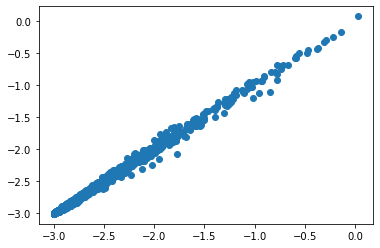

In [30]:
L = 6
structure = "chain"
V = 1
state = "ground"
result = runNNSystem(data_directory="data/", L=L, structure=structure, V=V, state=state)

'''
plt.plot(result[0].history['loss'][1:])
#plt.figure(0)
plt.title("L=" + str(L) + ", V=" + str(V) + ", structure=" + structure + ", state=" + state)
plt.xlabel("Epoch")
plt.ylabel("Loss")
'''

y_pred = np.array(result[2])
y_test = np.array(result[3])


#y_diff = y_test - y_pred

plt.plot(y_test, y_pred,'o')

# 0.0121

# 100-32-20-1 = 4613 params
# 150-20-1 = 4091
# 400-32-20-1 = 16313
# 250-20-1= 6791
# 100-20-1 = 2741

In [21]:
mse = tf.keras.losses.MeanSquaredError()
mse(y_test, y_pred).numpy()

0.38117304

Text(0, 0.5, 'Predicted Value')

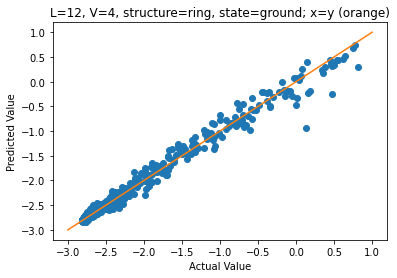

In [282]:
y_pred = np.array(result[2])
y_test = np.array(result[3])
plt.plot(y_test, y_pred,'o')

t = np.linspace(-3, 1, len(y_test))
plt.plot(t,t)

plt.title("L=" + str(L) + ", V=" + str(V) + ", structure=" + structure + ", state=" + state + "; x=y (orange)")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")

Text(0, 0.5, '(actual value-prediction)**2')

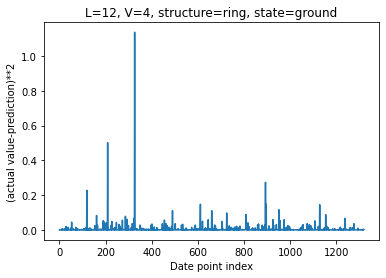

In [281]:
y_pred = np.array(result[2]).flatten()
y_test = np.array(result[3]).flatten()

y_diff = (y_test- y_pred)**2

#y_pred.shape(len(y_pred))

#plt.plot(y_diff)

#plt.plot(y_test, y_pred,'o')

#t = np.linspace(-4.5, 0.5, len(y_test))

plt.plot(y_diff)

plt.title("L=" + str(L) + ", V=" + str(V) + ", structure=" + structure + ", state=" + state)
plt.xlabel("Date point index")
plt.ylabel("(actual value-prediction)**2")

In [72]:
Ls = [4,6,8,10]
structures=["chain", "ring"]
Vs = [1,4,6]
states = ["ground","first"]


'''
Ls = [4]
structures=["chain"]
Vs = [1,4,6]
states = ["ground"]
'''

results = []

mse = tf.keras.losses.MeanSquaredError()


for state in states:
    for L in Ls:
        for structure in structures:
            for V in Vs:
                en = runNNSystem(L=L, structure=structure, V=V, state=state)
                y_pred = np.array(en[2])
                y_test = np.array(en[3])
                error = mse(y_test, y_pred).numpy()
                results.append([state,L,structure,V,en[1],error])
                #print("hist", en[0].history['loss'][1:])
                #plt.plot(en[0].history['loss'][1:])
        #print(results)
                
print("Fin")

['4_2_chain_1_0001_ground.csv', '4_2_chain_1_001_ground.csv', '4_2_chain_1_005_ground.csv', '4_2_chain_1_01_ground.csv', '4_2_chain_1_05_ground.csv', '4_2_chain_1_1_ground.csv', '4_2_chain_1_2_ground.csv', '4_2_chain_1_3_ground.csv']
Length 8000
Model: "sequential_270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_931 (Dense)            (None, 100)               500       
_________________________________________________________________
dense_932 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_933 (Dense)            (None, 20)                660       
_________________________________________________________________
dense_934 (Dense)            (None, 1)                 21        
Total params: 4,413
Trainable params: 4,413
Non-trainable params: 0
_________________________________________________________________
No

168/168 [==============================] - 0s 1ms/step - loss: 3.5518e-04
Epoch 15/40
168/168 [==============================] - 0s 1ms/step - loss: 3.6575e-04
Epoch 16/40
168/168 [==============================] - 0s 1ms/step - loss: 3.0946e-04
Epoch 17/40
168/168 [==============================] - 0s 1ms/step - loss: 2.8574e-04
Epoch 18/40
168/168 [==============================] - 0s 1ms/step - loss: 2.8626e-04
Epoch 19/40
168/168 [==============================] - 0s 1ms/step - loss: 2.7789e-04
Epoch 20/40
168/168 [==============================] - 0s 1ms/step - loss: 2.8367e-04
Epoch 21/40
168/168 [==============================] - 0s 1ms/step - loss: 3.4481e-04
Epoch 22/40
168/168 [==============================] - 0s 1ms/step - loss: 2.5558e-04
Epoch 23/40
168/168 [==============================] - 0s 1ms/step - loss: 2.7715e-04
Epoch 24/40
168/168 [==============================] - 0s 1ms/step - loss: 2.7736e-04
Epoch 25/40
168/168 [==============================] - 0s 1ms/step

168/168 [==============================] - 0s 755us/step - loss: 0.0336
Epoch 2/40
168/168 [==============================] - 0s 698us/step - loss: 0.0011
Epoch 3/40
168/168 [==============================] - 0s 809us/step - loss: 0.0011
Epoch 4/40
168/168 [==============================] - 0s 985us/step - loss: 0.0010
Epoch 5/40
168/168 [==============================] - 0s 899us/step - loss: 9.9074e-04
Epoch 6/40
168/168 [==============================] - 0s 819us/step - loss: 9.5244e-04
Epoch 7/40
168/168 [==============================] - 0s 881us/step - loss: 9.2800e-04
Epoch 8/40
168/168 [==============================] - 0s 1ms/step - loss: 9.1037e-04
Epoch 9/40
168/168 [==============================] - 0s 1ms/step - loss: 8.7430e-04
Epoch 10/40
168/168 [==============================] - 0s 1ms/step - loss: 8.4655e-04
Epoch 11/40
168/168 [==============================] - 0s 1ms/step - loss: 8.2959e-04
Epoch 12/40
168/168 [==============================] - 0s 1ms/step - loss: 8

Length 8000
Model: "sequential_277"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_959 (Dense)            (None, 100)               700       
_________________________________________________________________
dense_960 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_961 (Dense)            (None, 20)                660       
_________________________________________________________________
dense_962 (Dense)            (None, 1)                 21        
Total params: 4,613
Trainable params: 4,613
Non-trainable params: 0
_________________________________________________________________
None
Training L=6 V=4 structure=chain state=ground
Epoch 1/40
168/168 [==============================] - 1s 844us/step - loss: 0.2868
Epoch 2/40
168/168 [==============================] - 0s 978us/step - loss: 0.0146
Epoch 3/40
168/168 

168/168 [==============================] - 0s 1ms/step - loss: 5.6938e-04
Epoch 18/40
168/168 [==============================] - 0s 978us/step - loss: 5.8866e-04
Epoch 19/40
168/168 [==============================] - 0s 1ms/step - loss: 5.5259e-04
Epoch 20/40
168/168 [==============================] - 0s 1ms/step - loss: 5.6978e-04
Epoch 21/40
168/168 [==============================] - 0s 1ms/step - loss: 5.3376e-04
Epoch 22/40
168/168 [==============================] - 0s 788us/step - loss: 5.6340e-04
Epoch 23/40
168/168 [==============================] - 0s 821us/step - loss: 4.6184e-04
Epoch 24/40
168/168 [==============================] - 0s 997us/step - loss: 4.9028e-04
Epoch 25/40
168/168 [==============================] - 0s 1ms/step - loss: 5.1815e-04
Epoch 26/40
168/168 [==============================] - 0s 1ms/step - loss: 5.7051e-04
Epoch 27/40
168/168 [==============================] - 0s 1ms/step - loss: 4.4549e-04
Epoch 28/40
168/168 [==============================] - 0s 

168/168 [==============================] - 0s 659us/step - loss: 0.6552
Epoch 2/40
168/168 [==============================] - 0s 750us/step - loss: 0.0271
Epoch 3/40
168/168 [==============================] - 0s 783us/step - loss: 0.0116
Epoch 4/40
168/168 [==============================] - 0s 813us/step - loss: 0.0069
Epoch 5/40
168/168 [==============================] - 0s 917us/step - loss: 0.0051
Epoch 6/40
168/168 [==============================] - 0s 871us/step - loss: 0.0045
Epoch 7/40
168/168 [==============================] - 0s 979us/step - loss: 0.0036
Epoch 8/40
168/168 [==============================] - 0s 947us/step - loss: 0.0033
Epoch 9/40
168/168 [==============================] - 0s 884us/step - loss: 0.0029
Epoch 10/40
168/168 [==============================] - 0s 922us/step - loss: 0.0026
Epoch 11/40
168/168 [==============================] - 0s 931us/step - loss: 0.0024
Epoch 12/40
168/168 [==============================] - 0s 879us/step - loss: 0.0022
Epoch 13/40


Length 8000
Model: "sequential_286"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_995 (Dense)            (None, 100)               900       
_________________________________________________________________
dense_996 (Dense)            (None, 32)                3232      
_________________________________________________________________
dense_997 (Dense)            (None, 20)                660       
_________________________________________________________________
dense_998 (Dense)            (None, 1)                 21        
Total params: 4,813
Trainable params: 4,813
Non-trainable params: 0
_________________________________________________________________
None
Training L=8 V=4 structure=ring state=ground
Epoch 1/40
168/168 [==============================] - 1s 735us/step - loss: 0.3313
Epoch 2/40
168/168 [==============================] - 0s 812us/step - loss: 0.0471
Epoch 3/40
168/168 [

168/168 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 19/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 20/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 21/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 22/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 23/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 24/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 25/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 26/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 27/40
168/168 [==============================] - 0s 986us/step - loss: 0.0033
Epoch 28/40
168/168 [==============================] - 0s 958us/step - loss: 0.0032
Epoch 29/40
168/168 [==============================] - 0s 973us/step - loss: 0.0029
Epoch 30/40
168/168 [=

168/168 [==============================] - 1s 651us/step - loss: 0.2471
Epoch 2/40
168/168 [==============================] - 0s 738us/step - loss: 0.0910
Epoch 3/40
168/168 [==============================] - 0s 813us/step - loss: 0.0298
Epoch 4/40
168/168 [==============================] - 0s 791us/step - loss: 0.0074
Epoch 5/40
168/168 [==============================] - 0s 771us/step - loss: 0.0048
Epoch 6/40
168/168 [==============================] - 0s 915us/step - loss: 0.0040
Epoch 7/40
168/168 [==============================] - 0s 881us/step - loss: 0.0038
Epoch 8/40
168/168 [==============================] - 0s 887us/step - loss: 0.0039
Epoch 9/40
168/168 [==============================] - 0s 947us/step - loss: 0.0034
Epoch 10/40
168/168 [==============================] - 0s 974us/step - loss: 0.0037
Epoch 11/40
168/168 [==============================] - 0s 947us/step - loss: 0.0033
Epoch 12/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 13/40
16

168/168 [==============================] - 0s 690us/step - loss: 0.0307
Epoch 2/40
168/168 [==============================] - 0s 741us/step - loss: 0.0244
Epoch 3/40
168/168 [==============================] - 0s 977us/step - loss: 0.0193
Epoch 4/40
168/168 [==============================] - 0s 950us/step - loss: 0.0164
Epoch 5/40
168/168 [==============================] - 0s 897us/step - loss: 0.0147
Epoch 6/40
168/168 [==============================] - 0s 939us/step - loss: 0.0140
Epoch 7/40
168/168 [==============================] - 0s 845us/step - loss: 0.0138
Epoch 8/40
168/168 [==============================] - 0s 941us/step - loss: 0.0131
Epoch 9/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 10/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 11/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 12/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 13/40
168/168 

168/168 [==============================] - 0s 783us/step - loss: 0.2224
Epoch 2/40
168/168 [==============================] - 0s 757us/step - loss: 0.0236
Epoch 3/40
168/168 [==============================] - 0s 867us/step - loss: 0.0107
Epoch 4/40
168/168 [==============================] - 0s 889us/step - loss: 0.0075
Epoch 5/40
168/168 [==============================] - 0s 977us/step - loss: 0.0067
Epoch 6/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 7/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 8/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 9/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 10/40
168/168 [==============================] - 0s 901us/step - loss: 0.0064
Epoch 11/40
168/168 [==============================] - 0s 834us/step - loss: 0.0061
Epoch 12/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 13/40
168/168 [=

168/168 [==============================] - 1s 792us/step - loss: 0.0295
Epoch 2/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 3/40
168/168 [==============================] - 0s 914us/step - loss: 0.0080
Epoch 4/40
168/168 [==============================] - 0s 914us/step - loss: 0.0055
Epoch 5/40
168/168 [==============================] - 0s 917us/step - loss: 0.0044
Epoch 6/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 7/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 8/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 9/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 10/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 11/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 12/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 13/40
168/168 [=======

Length 8000
Model: "sequential_301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1055 (Dense)           (None, 100)               700       
_________________________________________________________________
dense_1056 (Dense)           (None, 32)                3232      
_________________________________________________________________
dense_1057 (Dense)           (None, 20)                660       
_________________________________________________________________
dense_1058 (Dense)           (None, 1)                 21        
Total params: 4,613
Trainable params: 4,613
Non-trainable params: 0
_________________________________________________________________
None
Training L=6 V=4 structure=chain state=first
Epoch 1/40
168/168 [==============================] - 0s 733us/step - loss: 0.2309
Epoch 2/40
168/168 [==============================] - 0s 776us/step - loss: 0.0381
Epoch 3/40
168/168 [

168/168 [==============================] - 0s 1ms/step - loss: 0.0070
Epoch 23/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 24/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 25/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 26/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 27/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 28/40
168/168 [==============================] - 0s 971us/step - loss: 0.0059
Epoch 29/40
168/168 [==============================] - 0s 995us/step - loss: 0.0056
Epoch 30/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 31/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 32/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 33/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 34/40
168/168 [===

168/168 [==============================] - 0s 1ms/step - loss: 0.0188
Epoch 12/40
168/168 [==============================] - 0s 945us/step - loss: 0.0185
Epoch 13/40
168/168 [==============================] - 0s 973us/step - loss: 0.0179
Epoch 14/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0192
Epoch 15/40
168/168 [==============================] - 0s 994us/step - loss: 0.0178
Epoch 16/40
168/168 [==============================] - 0s 980us/step - loss: 0.0167
Epoch 17/40
168/168 [==============================] - 0s 986us/step - loss: 0.0169
Epoch 18/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 19/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0165
Epoch 20/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0169
Epoch 21/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0169
Epoch 22/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 23/40
168/16

168/168 [==============================] - 0s 757us/step - loss: 0.2860
Epoch 2/40
168/168 [==============================] - 0s 792us/step - loss: 0.0925
Epoch 3/40
168/168 [==============================] - 0s 760us/step - loss: 0.0544
Epoch 4/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0449
Epoch 5/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0370
Epoch 6/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 7/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0276
Epoch 8/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0257
Epoch 9/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0244
Epoch 10/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 11/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 12/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 13/40
168/168 [=========

168/168 [==============================] - 1s 878us/step - loss: 0.5930
Epoch 2/40
168/168 [==============================] - 0s 943us/step - loss: 0.1318
Epoch 3/40
168/168 [==============================] - 0s 934us/step - loss: 0.0755
Epoch 4/40
168/168 [==============================] - 0s 897us/step - loss: 0.0552
Epoch 5/40
168/168 [==============================] - 0s 865us/step - loss: 0.0436
Epoch 6/40
168/168 [==============================] - 0s 921us/step - loss: 0.0349
Epoch 7/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0292
Epoch 8/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 9/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0255
Epoch 10/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 11/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 12/40
168/168 [==============================] - 0s 1000us/step - loss: 0.0217
Epoch 13/40
168/168 [

168/168 [==============================] - 1s 859us/step - loss: 2.9070
Epoch 2/40
168/168 [==============================] - 0s 951us/step - loss: 0.1402
Epoch 3/40
168/168 [==============================] - 0s 947us/step - loss: 0.0619
Epoch 4/40
168/168 [==============================] - 0s 977us/step - loss: 0.0419
Epoch 5/40
168/168 [==============================] - 0s 996us/step - loss: 0.0332
Epoch 6/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 7/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0260
Epoch 8/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0260
Epoch 9/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0242
Epoch 10/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0255
Epoch 11/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 12/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 13/40
168/168 [=====

168/168 [==============================] - 0s 703us/step - loss: 0.6237
Epoch 2/40
168/168 [==============================] - 0s 775us/step - loss: 0.1024
Epoch 3/40
168/168 [==============================] - 0s 901us/step - loss: 0.0693
Epoch 4/40
168/168 [==============================] - 0s 912us/step - loss: 0.0582
Epoch 5/40
168/168 [==============================] - 0s 961us/step - loss: 0.0525
Epoch 6/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0469
Epoch 7/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0433
Epoch 8/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 9/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0385
Epoch 10/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0347
Epoch 11/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0338
Epoch 12/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0327
Epoch 13/40
168/168 [=====

168/168 [==============================] - 1s 859us/step - loss: 0.8321
Epoch 2/40
168/168 [==============================] - 0s 937us/step - loss: 0.0796
Epoch 3/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0622
Epoch 4/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0496
Epoch 5/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0379
Epoch 6/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0292
Epoch 7/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 8/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0229
Epoch 9/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 10/40
168/168 [==============================] - 0s 1ms/step - loss: 0.0197
Epoch 11/40
168/168 [==============================] - 0s 960us/step - loss: 0.0179
Epoch 12/40
168/168 [==============================] - 0s 948us/step - loss: 0.0186
Epoch 13/40
168/168 [=======

In [73]:
results

[['ground', 4, 'chain', 1, 0.00013624673010781407, 0.17374328],
 ['ground', 4, 'chain', 4, 0.00014674007252324373, 0.08866882],
 ['ground', 4, 'chain', 6, 0.0001839900651248172, 0.08822001],
 ['ground', 4, 'ring', 1, 0.00021696447220165282, 0.08085992],
 ['ground', 4, 'ring', 4, 0.00016837930888868868, 0.017790506],
 ['ground', 4, 'ring', 6, 0.00033430138137191534, 0.0018315233],
 ['ground', 6, 'chain', 1, 0.0014583300799131393, 0.4004643],
 ['ground', 6, 'chain', 4, 0.0006446203915402293, 0.18007497],
 ['ground', 6, 'chain', 6, 0.0005624198820441961, 0.15129878],
 ['ground', 6, 'ring', 1, 0.0008782659424468875, 0.34209558],
 ['ground', 6, 'ring', 4, 0.00038892467273399234, 0.11692424],
 ['ground', 6, 'ring', 6, 0.00035733895492739975, 0.030374827],
 ['ground', 8, 'chain', 1, 0.0019375233678147197, 0.6486267],
 ['ground', 8, 'chain', 4, 0.0024154470302164555, 0.38121513],
 ['ground', 8, 'chain', 6, 0.0025122330989688635, 0.22766386],
 ['ground', 8, 'ring', 1, 0.0024032024666666985, 0.4

In [74]:
df = pd.DataFrame(results, columns =['state', 'L', 'structure', 'V', 'Loss','mse'], dtype = float)
df.to_csv("data/results/data_1000_nn_100_32_20_e40.csv", encoding='utf-8', index=False)

df

,state,L,structure,V,Loss,mse
0,ground,4.0,chain,1.0,0.000136,0.173743
1,ground,4.0,chain,4.0,0.000147,0.088669
2,ground,4.0,chain,6.0,0.000184,0.088220
3,ground,4.0,ring,1.0,0.000217,0.080860
4,ground,4.0,ring,4.0,0.000168,0.017791
5,ground,4.0,ring,6.0,0.000334,0.001832
6,ground,6.0,chain,1.0,0.001458,0.400464
7,ground,6.0,chain,4.0,0.000645,0.180075
8,ground,6.0,chain,6.0,0.000562,0.151299
9,ground,6.0,ring,1.0,0.000878,0.342096


In [50]:
df = pd.DataFrame(results, columns =['state', 'L', 'structure', 'V', 'Energy'], dtype = float)
df.to_csv("data/results/nn_100_20_e15.csv", encoding='utf-8', index=False)

df

,state,L,structure,V,Energy
0,ground,4.0,chain,1.0,0.001039
1,ground,4.0,chain,4.0,0.002201
2,ground,4.0,chain,6.0,0.000472
3,ground,4.0,ring,1.0,0.000630
4,ground,4.0,ring,4.0,0.001471
5,ground,4.0,ring,6.0,0.000536
6,ground,6.0,chain,1.0,0.003296
7,ground,6.0,chain,4.0,0.012775
8,ground,6.0,chain,6.0,0.001722
9,ground,6.0,ring,1.0,0.002240


In [ ]:
tl_energies = two_layer_df["Energy"]
ol_energies = one_layer_df["Energy"]

energy_results = []
for i, ol_en in enumerate(ol_energies):
    print(i, ol_en-tl_energies[i])
    
    if ol_en<tl_energies[i]:
        energy_results.append(1)
    else:
        energy_results.append(2)
        
energy_results

print("Results", energy_results.count(1), energy_results.count(2))


In [197]:
dfs = [df_150_20_e40,df_150_20_e50]

result = []

for i in range(len(dfs[0])):
    loss_list = []
    for df in dfs:
        loss_list.append(df['Energy'][i])
    result.append(loss_list.index(min(loss_list)))
    print(i)
    
print("Results", result.count(0), result.count(1))

# Results
# Round 1: Results 7 13 19 21
# Round 2: Results 33 27
# Round 3: Results 14 46
# Round 3: Results 16 44
# Round 3: Results 29 31
# Round 3: Results 23 37

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
Results 29 31


In [76]:
df_d1000_nn_100_32_20_e40 = pd.read_csv("data/results/data_1000_nn_100_32_20_e40.csv")
df_d750_nn_150_20_e40 = pd.read_csv("data/results/data_750_nn_150_20_e40.csv")

In [77]:
print("new","old")

result = []

for i in range(len(df_d750_nn_150_20_e40)):
    ans = [df_d1000_nn_100_32_20_e40['mse'][i],df_d750_nn_150_20_e40['mse'][i]]
    result.append(ans.index(min(ans)))
    print(df_d1000_nn_100_32_20_e40['mse'][i],df_d750_nn_150_20_e40['mse'][i])

print("Results", result.count(0), result.count(1))

new old
0.1737432777881622 0.1545952707529068
0.0886688232421875 0.0919009894132614
0.0882200077176094 0.0889001935720443
0.0808599218726158 0.085291177034378
0.0177905056625604 0.0152748627588152
0.0018315232591703 0.0016265506856143
0.4004642963409424 0.3682130873203277
0.1800749748945236 0.1869878619909286
0.151298776268959 0.142275184392929
0.3420955836772918 0.3391407132148742
0.1169242411851883 0.1318703889846801
0.030374826863408 0.0362788438796997
0.6486266851425171 0.6746001243591309
0.3812151253223419 0.3082552552223205
0.2276638597249984 0.2232505679130554
0.4991235435009002 0.4484128355979919
0.2231934964656829 0.2097342014312744
0.0619056411087513 0.064359538257122
1.024041771888733 1.0440272092819214
0.5604258179664612 0.5269119739532471
0.3392823338508606 0.2984488606452942
1.1048157215118408 0.9477753639221193
0.4902627766132355 0.5252843499183655
0.2361625432968139 0.1930091083049774
0.1120050624012947 0.1103487014770507
0.0561613142490386 0.0599932111799716
0.02973532

In [4]:
df_100_10_e15 = pd.read_csv("data/results/nn_100_10_e15.csv")
df_100_20_e15 = pd.read_csv("data/results/nn_100_20_e15.csv")
df_150_20_e13 = pd.read_csv("data/results/nn_150_20_e13.csv")
df_150_20_e15 = pd.read_csv("data/results/nn_150_20_e15.csv")
df_150_20_e20 = pd.read_csv("data/results/nn_150_20_e20.csv")
df_150_20_e25 = pd.read_csv("data/results/nn_150_20_e25.csv")
df_150_20_e30 = pd.read_csv("data/results/nn_150_20_e30.csv")
df_150_20_e35 = pd.read_csv("data/results/nn_150_20_e35.csv")
df_150_20_e40 = pd.read_csv("data/results/nn_150_20_e40.csv")
df_150_20_e50 = pd.read_csv("data/results/nn_150_20_e50.csv")
df_d750_nn_150_20_e40 = pd.read_csv("data/results/data_750_nn_150_20_e40.csv")

In [5]:
df_d750_nn_150_20_e40

,state,L,structure,V,Loss,mse
0,ground,4.0,chain,1.0,0.000322,0.154595
1,ground,4.0,chain,4.0,0.000328,0.091901
2,ground,4.0,chain,6.0,0.000052,0.088900
3,ground,4.0,ring,1.0,0.000162,0.085291
4,ground,4.0,ring,4.0,0.000111,0.015275
5,ground,4.0,ring,6.0,0.000281,0.001627
6,ground,6.0,chain,1.0,0.002147,0.368213
7,ground,6.0,chain,4.0,0.004369,0.186988
8,ground,6.0,chain,6.0,0.000439,0.142275
9,ground,6.0,ring,1.0,0.001463,0.339141


In [12]:
# L N type V T

data_columns = {'wave_function', 'densities', 'total_energy','hopping_energy','onsite_energy','interaction_energy','onsite_energies'}

result_ground_df = pd.DataFrame(columns=data_columns)
result_first_df = pd.DataFrame(columns=data_columns)

L = 4
N = 2

is_chains = [False]
Vs = [4]
deltas = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 3]

overall_num_of_data_points = [4000,6000,8000,10000,12000,14000,16000,18000,20000]

for is_chain in is_chains:
    data_type = "chain"
    if is_chain == False:
        data_type = "ring"
    for V in Vs:
        for delta in deltas:
            for num_of_data_points in overall_num_of_data_points:
                file_name_prefix = "data/diff_data_sizes/" + str(num_of_data_points) + "_" + str(L) + "_" + str(N) + "_" + data_type + "_" + str(V) + "_" + getDeltaString(delta) + "_"
                print(file_name_prefix)
                result_ground_df = pd.DataFrame(columns=data_columns)
                result_first_df = pd.DataFrame(columns=data_columns)
                for i in range(int(num_of_data_points/8)):
                    if i % 100 == 0:
                        print(i)
                    result = generateTrainingData(L=L, N=N, on_site_energies=list(np.random.uniform(-1*delta,delta,L)), t=1, V=V, is_chain=is_chain)
                    result_ground_df = result_ground_df.append(result[0],ignore_index=True)
                    result_first_df = result_first_df.append(result[1],ignore_index=True)
                result_ground_df.to_csv(file_name_prefix + "ground.csv", encoding='utf-8', index=False)
                result_first_df.to_csv(file_name_prefix + "first.csv", encoding='utf-8', index=False)
            

print("Fin")

data/diff_data_sizes/4000_4_2_ring_4_0001_
0
100
200
300
400
data/diff_data_sizes/6000_4_2_ring_4_0001_
0
100
200
300
400
500
600
700
data/diff_data_sizes/8000_4_2_ring_4_0001_
0
100
200
300
400
500
600
700
800
900
data/diff_data_sizes/10000_4_2_ring_4_0001_
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
data/diff_data_sizes/12000_4_2_ring_4_0001_
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
data/diff_data_sizes/14000_4_2_ring_4_0001_
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
data/diff_data_sizes/16000_4_2_ring_4_0001_
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
data/diff_data_sizes/18000_4_2_ring_4_0001_
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
data/diff_data_sizes/20000_4_2_ring_4_0001_
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
data/diff_data_sizes/40

In [10]:
df = pd.read_csv("data/diff_data_sizes/4000_4_2_ring_4_0001_ground.csv")

In [11]:
df

,densities,wave_function,total_energy,onsite_energies,hopping_energy,interaction_energy,onsite_energy
0,[0.07321184 0.92680851 0.07319879 0.92678085],[ 1.91345631e-01 3.95671860e-06 -1.91307847e-...,-0.829264,"[-2.1767870267215507e-05, 0.000551548086481354...",-1.414070,0.585643,-0.000837
1,[0.92676816 0.07321985 0.92680032 0.07321168],[-1.91314764e-01 -9.23887696e-01 -1.91306937e-...,-0.829189,"[7.02922473559311e-05, -0.0009360545407597217,...",-1.414153,0.585726,-0.000762
2,[0.9267577 0.07321065 0.92680499 0.07322667],[-1.91300931e-01 -9.23884563e-01 -1.91308563e-...,-0.828026,"[0.00013162266801192862, -0.000594495886795188...",-1.414176,0.585749,0.000401
3,[0.92677929 0.07322002 0.92677651 0.07322418],[-1.91338845e-01 -9.23880839e-01 -1.91345070e-...,-0.829766,"[-0.0006877100920672315, -0.000627806794614547...",-1.414204,0.585777,-0.001339
4,[0.07322445 0.92679201 0.07319311 0.92679042],[ 1.91344396e-01 6.76833566e-07 -1.91342037e-...,-0.830221,"[-0.0009186027298019275, 0.0002294235165153724...",-1.414097,0.585670,-0.001793
...,...,...,...,...,...,...,...
495,[0.9267761 0.07319598 0.92680005 0.07322787],[-1.91293110e-01 -9.23891847e-01 -1.91329298e-...,-0.829373,"[-0.000521576067969225, -0.0009055794941807609...",-1.414123,0.585695,-0.000946
496,[0.92679251 0.07320125 0.92678189 0.07322434],[-1.91318893e-01 -9.23890903e-01 -1.91350972e-...,-0.829761,"[-0.0006067344706134952, -0.000526296619187238...",-1.414130,0.585702,-0.001333
497,[0.07323018 0.92675542 0.0732179 0.9267965 ],[ 1.91132739e-01 -9.16970441e-04 -1.91566216e-...,-0.828638,"[-0.0007826427418281139, 0.0001000062928023007...",-1.414213,0.585786,-0.000211
498,[0.92677802 0.07322025 0.92677833 0.07322339],[-1.91337552e-01 -9.23881135e-01 -1.91341601e-...,-0.826916,"[0.000765645659599905, 0.0007452280332205183, ...",-1.414202,0.585775,0.001511


In [3]:
def getFilenamesForOverall(data_directory="data/diff_data_sizes/", L=4, structure = "ring", V=4, state ="ground", num_of_points=4000):
    files = os.listdir(data_directory)
    result = []
    for filename in files:
        file_options = filename.split("_")
        if file_options[0] == str(num_of_points):
            if file_options[1] == str(L):
                if file_options[3] == structure:
                    if file_options[4] == str(V):
                        if file_options[6] == state + ".csv":
                            result.append(filename)
    return result

def getFileData(filename, filedirectory="data/diff_data_sizes/"):
    file = open(filedirectory + filename)
    csvreader = csv.reader(file)
    
    header = []
    header = next(csvreader)
    
    rows = []
    for row in csvreader:
        rows.append(row)
        
    return {"headers": header, "rows": rows}

# densities,wave_function,total_energy,onsite_energies,hopping_energy,interaction_energy,onsite_energy
def splitData(data,L):
    input_list = []
    output_list = []
    for row in data["rows"]:
        
        # nums
        densities = formatDensities(row[0])
        total_energy = float(row[2])
        onsite_energy = float(row[6])
        

        input_list.append(densities)

        output_energy = total_energy - onsite_energy
        output_list.append(output_energy)
        
    return {"input": input_list, "output": output_list}


def formatDensities(den):
    den = den.replace("[","")
    den = den.replace("]","")
    dots = getPositionOfCharacters(den, ".")
    starts = np.array(dots) - 1
    spaces = getPositionOfCharacters(den, " ")
    
    numbers = []
    
    for start in starts:
        end = getNextLargest(start, spaces)
        if end != 0:
            numbers.append(den[start:end])
        else:
            numbers.append(den[start:])
    
    
    return [float(i) for i in numbers]

def getPositionOfCharacters(s, c):
    return [pos for pos, char in enumerate(s) if char == c]

def getNextLargest(val, input_list):
    ans = 0
    for value in input_list:
        if val < value:
            ans = value 
            break
    return ans


def runNNSystemForOverall(data_directory="data/diff_data_sizes/", L=4, structure = "ring", V=4, state ="ground", num_of_points=4000):
    filenames = getFilenamesForOverall(data_directory, L, structure, V, state, num_of_points=num_of_points)
    print(filenames)
    input_data = []
    output_data = []
    for filename in filenames:
        split_data = splitData(getFileData(filename, data_directory),L)
        input_data.extend(split_data['input'])
        output_data.extend(split_data['output'])
        
    #print("Length", input_data)
    
    
    x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.33)
    
    model = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(L, )),
          tf.keras.layers.Dense(150, activation='relu'),
          tf.keras.layers.Dense(20, activation='relu'),
          tf.keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
              loss='mean_squared_error')
    
    print(model.summary())
    
    print("Training", "num=" + str(num_of_points) ,"L=" + str(L), "V=" + str(V), "structure=" + structure, "state=" + state)
    ans1 = model.fit(np.array(x_train), np.array(y_train), epochs=40,shuffle=True)#,validation_split=0.1)
                    
    print("Evaluating")
    ans2 = model.evaluate(x_test, y_test)
    
    y_predict = model.predict(x_test)
    
    return (ans1,ans2,y_predict,y_test, model)
    
        

#runNNSystemForOverall(num_of_points=20000)

In [4]:
nn = runNNSystemForOverall(num_of_points=4000)

['4000_4_2_ring_4_0001_ground.csv', '4000_4_2_ring_4_001_ground.csv', '4000_4_2_ring_4_005_ground.csv', '4000_4_2_ring_4_01_ground.csv', '4000_4_2_ring_4_05_ground.csv', '4000_4_2_ring_4_1_ground.csv', '4000_4_2_ring_4_2_ground.csv', '4000_4_2_ring_4_3_ground.csv']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               750       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                3020      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 3,791
Trainable params: 3,791
Non-trainable params: 0
_________________________________________________________________
None
Training num=4000 L=4 V=4 structure=ring state=ground
Epoch 1/40
84/84 [==============================] - 0s 553u

In [42]:
pred = np.array(nn[2]).flatten()
test = np.array(nn[3]).flatten()

np.mean(np.power((pred - test),2))

0.00022476485592862322

In [4]:
overall_num_of_data_points = [4000,6000,8000,10000,12000,14000,16000,18000,20000]

#overall_num_of_data_points=[4000]

state = "ground"
L = 4
structure = "ring"
V = 4

results = []

mse = tf.keras.losses.MeanSquaredError()

for num_of_points in overall_num_of_data_points:
    print(num_of_points)
    en = runNNSystemForOverall(num_of_points=num_of_points)
    y_pred = np.array(en[2]).flatten()
    y_test = np.array(en[3]).flatten()
    error = mse(y_test, y_pred).numpy()
    results.append([num_of_points,state,L,structure,V,en[1],error])
    
print('Fin')

4000
['4000_4_2_ring_4_0001_ground.csv', '4000_4_2_ring_4_001_ground.csv', '4000_4_2_ring_4_005_ground.csv', '4000_4_2_ring_4_01_ground.csv', '4000_4_2_ring_4_05_ground.csv', '4000_4_2_ring_4_1_ground.csv', '4000_4_2_ring_4_2_ground.csv', '4000_4_2_ring_4_3_ground.csv']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               750       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                3020      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 3,791
Trainable params: 3,791
Non-trainable params: 0
_________________________________________________________________
None
Training num=4000 L=4 V=4 structure=ring state=ground
Epoch 1/40
84/84 [==============================] - 1s

210/210 [==============================] - 0s 1ms/step - loss: 9.5640e-05
Epoch 22/40
210/210 [==============================] - 0s 2ms/step - loss: 9.6560e-05
Epoch 23/40
210/210 [==============================] - 0s 1ms/step - loss: 9.3396e-05
Epoch 24/40
210/210 [==============================] - 0s 2ms/step - loss: 7.6616e-05
Epoch 25/40
210/210 [==============================] - 0s 2ms/step - loss: 8.6623e-05
Epoch 26/40
210/210 [==============================] - 0s 2ms/step - loss: 7.9142e-05A: 0s - loss: 8.1820e-0
Epoch 27/40
210/210 [==============================] - 0s 2ms/step - loss: 7.1902e-05
Epoch 28/40
210/210 [==============================] - 0s 2ms/step - loss: 1.0100e-04
Epoch 29/40
210/210 [==============================] - 0s 2ms/step - loss: 8.9366e-05
Epoch 30/40
210/210 [==============================] - 0s 2ms/step - loss: 7.1819e-05
Epoch 31/40
210/210 [==============================] - 0s 2ms/step - loss: 6.8055e-05
Epoch 32/40
210/210 [======================

294/294 [==============================] - 0s 2ms/step - loss: 5.5660e-04
Epoch 10/40
294/294 [==============================] - 0s 2ms/step - loss: 3.6066e-04
Epoch 11/40
294/294 [==============================] - 0s 1ms/step - loss: 2.7733e-04
Epoch 12/40
294/294 [==============================] - 0s 1ms/step - loss: 2.3686e-04
Epoch 13/40
294/294 [==============================] - 0s 2ms/step - loss: 1.9250e-04
Epoch 14/40
294/294 [==============================] - 0s 1ms/step - loss: 1.5294e-04
Epoch 15/40
294/294 [==============================] - 0s 1ms/step - loss: 1.5114e-04
Epoch 16/40
294/294 [==============================] - 0s 1ms/step - loss: 1.2604e-04
Epoch 17/40
294/294 [==============================] - 0s 2ms/step - loss: 1.2647e-04
Epoch 18/40
294/294 [==============================] - 0s 2ms/step - loss: 1.0037e-04
Epoch 19/40
294/294 [==============================] - 0s 2ms/step - loss: 1.1015e-04
Epoch 20/40
294/294 [==============================] - 0s 2ms/step

377/377 [==============================] - 1s 2ms/step - loss: 0.0181
Epoch 2/40
377/377 [==============================] - 1s 1ms/step - loss: 0.0042
Epoch 3/40
377/377 [==============================] - 1s 1ms/step - loss: 0.0021
Epoch 4/40
377/377 [==============================] - 1s 2ms/step - loss: 9.1035e-04
Epoch 5/40
377/377 [==============================] - 1s 2ms/step - loss: 4.1607e-04
Epoch 6/40
377/377 [==============================] - 1s 2ms/step - loss: 2.2008e-04
Epoch 7/40
377/377 [==============================] - 1s 2ms/step - loss: 1.7946e-04
Epoch 8/40
377/377 [==============================] - 1s 1ms/step - loss: 1.2744e-04
Epoch 9/40
377/377 [==============================] - 1s 1ms/step - loss: 9.8878e-05
Epoch 10/40
377/377 [==============================] - 1s 1ms/step - loss: 8.8585e-05
Epoch 11/40
377/377 [==============================] - 1s 2ms/step - loss: 7.8348e-05
Epoch 12/40
377/377 [==============================] - 1s 2ms/step - loss: 9.2996e-05


In [5]:
results

[[4000, 'ground', 4, 'ring', 4, 0.00014876389468554407, 0.00014876387],
 [6000, 'ground', 4, 'ring', 4, 0.0002795412437990308, 0.0002795413],
 [8000, 'ground', 4, 'ring', 4, 5.7566125178709626e-05, 5.7566143e-05],
 [10000, 'ground', 4, 'ring', 4, 0.00015354136121459305, 0.0001535414],
 [12000, 'ground', 4, 'ring', 4, 4.0803330193739384e-05, 4.0803323e-05],
 [14000, 'ground', 4, 'ring', 4, 0.00011355182505212724, 0.000113551825],
 [16000, 'ground', 4, 'ring', 4, 5.5919179430929944e-05, 5.591917e-05],
 [18000, 'ground', 4, 'ring', 4, 5.268208042252809e-05, 5.268208e-05],
 [20000, 'ground', 4, 'ring', 4, 6.69595756335184e-05, 6.6959605e-05]]

In [10]:
df = pd.DataFrame(results, columns =['num_of_points','state', 'L', 'structure', 'V', 'Loss', 'Loss_from_mse_function'], dtype = float)
df.to_csv("data/results/multi_data_points.csv", encoding='utf-8', index=False)
df

,num_of_points,state,L,structure,V,Loss,Loss_from_mse_function
0,4000.0,ground,4.0,ring,4.0,0.000149,0.000149
1,6000.0,ground,4.0,ring,4.0,0.000280,0.000280
2,8000.0,ground,4.0,ring,4.0,0.000058,0.000058
3,10000.0,ground,4.0,ring,4.0,0.000154,0.000154
4,12000.0,ground,4.0,ring,4.0,0.000041,0.000041
5,14000.0,ground,4.0,ring,4.0,0.000114,0.000114
6,16000.0,ground,4.0,ring,4.0,0.000056,0.000056
7,18000.0,ground,4.0,ring,4.0,0.000053,0.000053
8,20000.0,ground,4.0,ring,4.0,0.000067,0.000067


In [14]:
df = pd.read_csv("data/results/multi_data_points.csv")
df

,num_of_points,state,L,structure,V,Loss,Loss_from_mse_function
0,4000.0,ground,4.0,ring,4.0,0.000149,0.000149
1,6000.0,ground,4.0,ring,4.0,0.000280,0.000280
2,8000.0,ground,4.0,ring,4.0,0.000058,0.000058
3,10000.0,ground,4.0,ring,4.0,0.000154,0.000154
4,12000.0,ground,4.0,ring,4.0,0.000041,0.000041
5,14000.0,ground,4.0,ring,4.0,0.000114,0.000114
6,16000.0,ground,4.0,ring,4.0,0.000056,0.000056
7,18000.0,ground,4.0,ring,4.0,0.000053,0.000053
8,20000.0,ground,4.0,ring,4.0,0.000067,0.000067


In [6]:
for res in results:
    print(res[6]/res[5])

0.9999998043622714
1.0000002082256634
1.0000003159826023
1.0000002843256393
0.9999998216822602
1.0
0.9999998048265991
1.0
1.0000004346477733


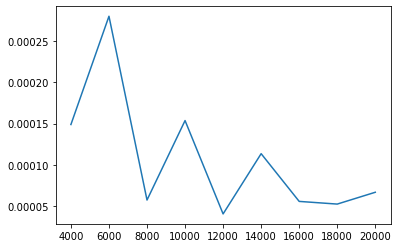

In [7]:
nums = []
loss = []
error = []

for line in results:
    nums.append(line[0])
    loss.append(line[5])
    error.append(line[6])
    
plt.plot(nums,loss)

In [65]:
def plot_diff_data_points_df(input_df):
    headings = input_df.iloc[0]
    
    nums = input_df['num_of_points']
    loss = input_df['Loss'] 
    plt.plot(nums,loss)
    plt.xlabel("Num of data points")
    plt.ylabel("Loss")
    plt.title("L=" + str(int(headings['L'])) + ",structure=" + headings['structure'] + ",V=" + str(int(headings['V'])) + ",state=" + headings['state'])
    

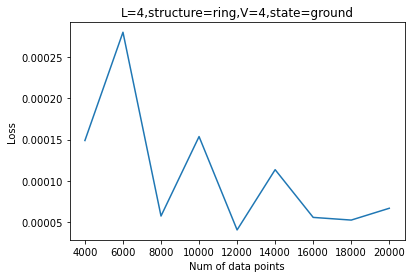

In [66]:
df = pd.read_csv("data/results/multi_data_points.csv")

plot_diff_data_points_df(df)

In [44]:
df.iloc[0]

num_of_points               4000.0
state                       ground
L                              4.0
structure                     ring
V                              4.0
Loss                      0.000149
Loss_from_mse_function    0.000149
Name: 0, dtype: object

In [5]:
nn = runNNSystemForOverall(num_of_points=20000)

['20000_4_2_ring_4_0001_ground.csv', '20000_4_2_ring_4_001_ground.csv', '20000_4_2_ring_4_005_ground.csv', '20000_4_2_ring_4_01_ground.csv', '20000_4_2_ring_4_05_ground.csv', '20000_4_2_ring_4_1_ground.csv', '20000_4_2_ring_4_2_ground.csv', '20000_4_2_ring_4_3_ground.csv']
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 150)               750       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                3020      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 3,791
Trainable params: 3,791
Non-trainable params: 0
_________________________________________________________________
None
Training num=20000 L=4 V=4 structure=ring state=ground
Epoch 1/40
419/419 [============================

In [8]:
nn[4].save('data/saved_models/nn_20000_points')

INFO:tensorflow:Assets written to: data/saved_models/nn_20000_points\assets


In [33]:
def getFilenamesForModelTest(data_directory="data/diff_data_sizes/", state="ground"):
    files = os.listdir(data_directory)
    result = []
    for filename in files:
        file_options = filename.split("_")
        if file_options[6] == state + ".csv":
            result.append(filename)
    return result


def test_model(nn, data_directory="data/diff_data_sizes/", L=4, structure = "ring", V=4, state ="ground"):
    filenames = getFilenamesForModelTest(data_directory, state=state)
    print(filenames)
    input_data = []
    output_data = []
    for filename in filenames:
        split_data = splitData(getFileData(filename, data_directory),L)
        input_data.extend(split_data['input'])
        output_data.extend(split_data['output'])
        
    y_test = output_data
    y_predict = nn.predict(input_data)
    
    
    mse = tf.keras.losses.MeanSquaredError()
    error = mse(np.array(y_test).flatten(), np.array(y_predict).flatten()).numpy()
    print("Error", error)
    
    return (y_test, y_predict)
    

In [34]:
# overall error = 6.15 * 10^-5

result = test_model(nn[4])

['10000_4_2_ring_4_0001_ground.csv', '10000_4_2_ring_4_001_ground.csv', '10000_4_2_ring_4_005_ground.csv', '10000_4_2_ring_4_01_ground.csv', '10000_4_2_ring_4_05_ground.csv', '10000_4_2_ring_4_1_ground.csv', '10000_4_2_ring_4_2_ground.csv', '10000_4_2_ring_4_3_ground.csv', '12000_4_2_ring_4_0001_ground.csv', '12000_4_2_ring_4_001_ground.csv', '12000_4_2_ring_4_005_ground.csv', '12000_4_2_ring_4_01_ground.csv', '12000_4_2_ring_4_05_ground.csv', '12000_4_2_ring_4_1_ground.csv', '12000_4_2_ring_4_2_ground.csv', '12000_4_2_ring_4_3_ground.csv', '14000_4_2_ring_4_0001_ground.csv', '14000_4_2_ring_4_001_ground.csv', '14000_4_2_ring_4_005_ground.csv', '14000_4_2_ring_4_01_ground.csv', '14000_4_2_ring_4_05_ground.csv', '14000_4_2_ring_4_1_ground.csv', '14000_4_2_ring_4_2_ground.csv', '14000_4_2_ring_4_3_ground.csv', '16000_4_2_ring_4_0001_ground.csv', '16000_4_2_ring_4_001_ground.csv', '16000_4_2_ring_4_005_ground.csv', '16000_4_2_ring_4_01_ground.csv', '16000_4_2_ring_4_05_ground.csv', '16000

Text(0, 0.5, 'Predicted Value')

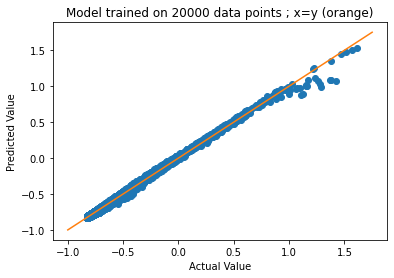

In [44]:
y_pred = np.array(result[1])
y_test = np.array(result[0])
plt.plot(y_test, y_pred,'o')

t = np.linspace(-1, 1.75, len(y_test))
plt.plot(t,t)

plt.title("Model trained on 20000 data points ; x=y (orange)")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")

In [3]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


<BarContainer object of 5 artists>

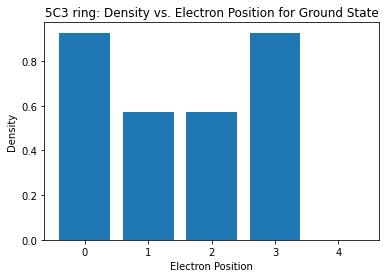

In [25]:
#plt.figure(eig_val_index)
plt.title("5C3 ring: Density vs. Electron Position for Ground State")
plt.xlabel("Electron Position")
plt.ylabel("Density")
#densities = [0.5,0.5,0.5,0.5]
#densities = [0.57575758,0.42424242,0.42424242,0.57575758]
densities = [9.26775563e-01,5.73223437e-01,5.73223437e-01,9.26775563e-01,1.99887822e-06]
plt.bar([str(i) for i in range(len(densities))], densities)

In [13]:
from keras.utils.vis_utils import plot_model

L= 6

model = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(L, )),
          tf.keras.layers.Dense(250, activation='relu'),
          tf.keras.layers.Dense(20, activation='relu'),
          #tf.keras.layers.Dense(10, activation='relu'),
          #tf.keras.layers.Dropout(0.05),
          tf.keras.layers.Dense(1, activation='linear')
    ])

#print(model.summary())
    

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

TypeError: plot_model() got an unexpected keyword argument 'show_layer_activations'

In [18]:
def generate_permutations(L, N):
    input_list = np.zeros(L, dtype=int)
    for i in range(N):
        input_list[i] = 1
    perms = list(itertools.permutations(input_list))
    unique_perms = list(dict.fromkeys(perms))
    return unique_perms


start = time.time()
generate_permutations(6,3)
end = time.time()
print("Time:", end - start)

Time: 0.0
